In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # or the full path to the "project" directory
import numpy as np
import gpbr

In [2]:
from gpbr.direct.common.boundary import Point3D
from gpbr.direct.common.distance import matpoint_distance, point_distance
def u3de(xp, t):
    point = Point3D(0,4, 0)
    dist =point_distance(point, xp)
    return 1/4/np.pi/t*np.exp(-dist**2/4/t)

def matu3de(X, t):
    Y = np.zeros_like(X)
    Y[1][:] = 4
    dist = matpoint_distance(X, Y)
    return 1/4/np.pi/t*np.exp(-dist**2/4/t)

In [3]:
from gpbr.direct.common.boundary import Point3D
def matf1(X, t: float) -> float:
    return np.zeros_like(X[0])

def matf2(X, t: float) -> float:
    return np.ones_like(X[0]) ## TODO: Add time dependence

In [4]:
from gpbr.direct.heat_equation.common import MFSConfig, Dimension

T = 1 # final time
N = 7 # N+1=10 time points

# Collocation 64 points
m1 = 8
m2 = 8
M_coll = m1 * m2 # number of collocation points
# Source
m1_source = 4
m2_source = 8
M_source = 2 * m1_source * m2_source


# # Collocation 256 points
# m1 = 16
# m2 = 16
# M_coll = m1 * m2 # number of collocation points
# # Source
# m1_source = 8
# m2_source = 16
# M_source = 2 * m1_source * m2_source


ETA1 = 0.5
ETA2 = 2.0
config = MFSConfig(
    N=N,
    n_coll=M_coll,
    n_source=M_source,
    T=T,
    eta1=ETA1,
    eta2=ETA2,
    f1=matf1,
    f2=matf2,
    dim = Dimension.THREE_D,
    n_coll_theta=m1,
    n_coll_phi=m2,
    n_source_theta=m1_source,
    n_source_phi=m2_source
)


In [5]:
from gpbr.direct.heat_equation.helpers import precalculate_mfs_data
mfs_data = precalculate_mfs_data(config)

In [6]:
def r2(theta, phi):
     return np.ones_like(theta)*0.8
def dr2_dtheta(theta, phi):
     return np.zeros_like(phi)
def dr2_dphi(theta, phi):
     return np.zeros_like(theta)

In [7]:
# # Define the radial function r(theta, phi)
def r1(theta, phi):
    return 0.45*(1 + 0.5 * np.sin(2 * theta) * np.cos(phi))  # Example radial function



# def r1(theta, phi):
#     return 0.2*(0.6 + np.sqrt(4.25+2*np.cos(3*theta)))

# def r1(theta, phi):
#     return 0.5*np.sqrt(0.8+0.2*(np.cos(2*phi)-1)*(np.cos(4*theta)-1))


# def r1(theta, phi):
#     return np.ones_like(theta)*0.5

# # Define the derivatives of r with respect to theta and phi
# def dr1_dtheta(theta, phi):
#     return 0.5 * 2 * np.cos(2 * theta) * np.cos(phi)

# def dr1_dphi(theta, phi):
#     return -0.5 * np.sin(2 * theta) * np.sin(phi)

In [8]:
from gpbr.direct.common.boundary import StarlikeSurface
Gamma2 = StarlikeSurface.from_radial_with_derivative(mfs_data.collocation, r2, dr2_dphi, dr2_dtheta)
Gamma2_source = StarlikeSurface.from_radial(mfs_data.source_collocation, lambda tetha,phi: ETA2*r2(tetha,phi))
Gamma2_rvals = r2(mfs_data.collocation.theta_grid, mfs_data.collocation.phi_grid)

In [9]:
%matplotlib widget
import matplotlib.pyplot as plt
def plot_poitns(Gamma: StarlikeSurface):
    fig_plot, ax_plot = plt.subplots(subplot_kw={"projection": "3d"})

    for p in Gamma.points:
        ax_plot.plot(p.x, p.y, p.z, 'bo')

    # Plot normals
    for p, n in zip(Gamma.points, Gamma.normals):
        ax_plot.quiver(p.x, p.y, p.z, n.x, n.y, n.z, color='r', length=0.5)

    # Set axis limits
    ax_plot.set_xlim3d([-3, 3])
    ax_plot.set_ylim3d([-3, 3])
    ax_plot.set_zlim3d([-3, 3])

    # Set axis labels
    ax_plot.set_xlabel('X axis')
    ax_plot.set_ylabel('Y axis')
    ax_plot.set_zlabel('Z axis')

    # Add grid and legend
    ax_plot.grid(True)
    ax_plot.legend()

    # Show the plot
    plt.show()

/var/folders/yp/sztpn13x2vq42vlgbb1zx8b80000gn/T/ipykernel_80752/1222809439.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_plot.legend()


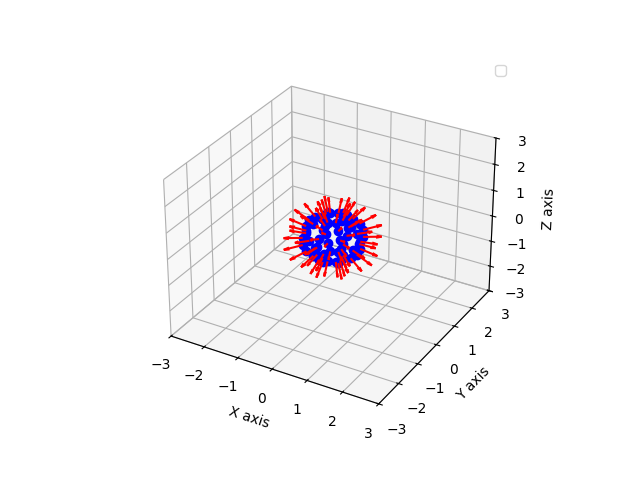

In [10]:
plot_poitns(Gamma2)

In [11]:
# # Gamma1_plot = StarlikeSurface.from_radial_with_derivative(mfs_data.collocation, r1, dr1_dphi, dr1_dtheta)
# Gamma1_plot = StarlikeSurface.from_radial(mfs_data.collocation, r1)
# plot_poitns(Gamma1_plot)

In [ ]:
from gpbr.direct.common.source import SourcePoints2D, SourcePoints3D
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence, fundamental_sequence_3d, matfundamental_sequence_3d
from gpbr.direct.heat_equation.helpers import dbu_3d, form_fs_matrix, form_fs_vector_2d, form_fs_vector_3d, matdbu_3d, matdbu_3d_all, matform_fs_vector_3d
from gpbr.direct.heat_equation.helpers import dbu_2d

from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs
from numpy.linalg import lstsq


def eval_for_g1(
        Gamma2: StarlikeSurface,
        Gamma2_source: StarlikeSurface,
        f1, f2,
        mfs_data,
        r1_func
    ):
    Gamma1 = StarlikeSurface.from_radial(mfs_data.collocation, r1_func)
    ## WARNING: source points should not include the scaling(ETA1,ETA2) factor
    # Gamma1_source = StarlikeSurface.from_radial(mfs_data.source_collocation, lambda theta,phi: ETA1*r1_func(theta,phi))
    src_cnt = Gamma1_source.collocation.n_phi * Gamma1_source.collocation.n_theta
    src_cnt+= Gamma2_source.collocation.n_phi * Gamma2_source.collocation.n_theta

    source_points = SourcePoints3D(src_cnt, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)


    fundamental_sequence_gamma1 = matfundamental_sequence_3d(Gamma1, source_points, mfs_data)
    fundamental_sequence_gamma2 = matfundamental_sequence_3d(Gamma2, source_points, mfs_data)
    PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)


    alpha_coeeff = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    alpha_coeeff[:] = np.nan
    fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
    for n in range(0, mfs_data.N+1):
        F = matform_fs_vector_3d(n,
                            fundamental_sequence_gamma1,
                            fundamental_sequence_gamma2,
                            Gamma1,
                            Gamma2,
                            fs_coefs,
                            f1, f2, mfs_data)
        try:
            alpha_n = lstsq(PHI_MAT, F)[0]
        except np.linalg.LinAlgError:
            print(f"Failed to solve the linear system for function {r1_func}")
            return None
        fs_coefs.alpha[n] = alpha_n.T
    du_vals = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    du_vals[:] = np.nan

    for ni in range(0, N+1):
        du_vals[ni] = matdbu_3d(Gamma2.mesh,Gamma2.normals_mesh, ni, source_points, fs_coefs, mfs_data).ravel()
    return du_vals
    # return matdbu_3d(Gamma2.mesh,Gamma2.normals_mesh, n, source_points, fs_coefs, mfs_data)

    # du_vals = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    # for n in range(0, N+1):
    #     for i, (x, nx) in enumerate(zip(Gamma2.points, Gamma2.normals)):
    #         du_vals[n, i] = dbu_3d(x, nx, n, source_points, fs_coefs, mfs_data)
    # return du_vals

    
def eval_for_g1_optimized(
        Gamma2: StarlikeSurface,
        Gamma2_source: StarlikeSurface,
        f1, f2,
        mfs_data,
        r1_func
    ):
    Gamma1 = StarlikeSurface.from_radial(mfs_data.collocation, r1_func)
    Gamma1_source = StarlikeSurface.from_radial(mfs_data.source_collocation, lambda theta,phi: ETA1*r1_func(theta,phi))
    src_cnt = Gamma1_source.collocation.n_phi * Gamma1_source.collocation.n_theta
    src_cnt+= Gamma2_source.collocation.n_phi * Gamma2_source.collocation.n_theta

    source_points = SourcePoints3D(src_cnt, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)


    fundamental_sequence_gamma1 = matfundamental_sequence_3d(Gamma1, source_points, mfs_data)
    fundamental_sequence_gamma2 = matfundamental_sequence_3d(Gamma2, source_points, mfs_data)
    PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)


    alpha_coeeff = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    alpha_coeeff[:] = np.nan
    fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
    for n in range(0, mfs_data.N+1):
        F = matform_fs_vector_3d(n,
                            fundamental_sequence_gamma1,
                            fundamental_sequence_gamma2,
                            Gamma1,
                            Gamma2,
                            fs_coefs,
                            f1, f2, mfs_data)
        try:
            alpha_n = lstsq(PHI_MAT, F)[0]
        except np.linalg.LinAlgError:
            print(f"Failed to solve the linear system for function {r1_func}")
            return None
        fs_coefs.alpha[n] = alpha_n.T

    return matdbu_3d_all(Gamma2.mesh,Gamma2.normals_mesh, mfs_data.N, source_points, fs_coefs, mfs_data).reshape((mfs_data.N+1, mfs_data.M))


In [13]:
# exact = eval_for_g1(Gamma2, Gamma2_source, matf1, matf2, mfs_data, r1)
exact = eval_for_g1_optimized(Gamma2, Gamma2_source, matf1, matf2, mfs_data, r1)

In [14]:
import numpy as np

def noise(vals, noise_level=0.01, seed=None):
    """
    Add static noise to the input values with a specified noise level.
    
    Parameters:
    -----------
    vals : numpy.ndarray
        Input array to which noise will be added.
    noise_level : float, optional
        The noise level, determining the magnitude of the random noise.
    seed : int, optional
        Seed for the random number generator to produce static noise.
        
    Returns:
    --------
    numpy.ndarray
        The input array with added noise.
    """
    if seed is not None:
        # Use a temporary random seed
        state = np.random.get_state()  # Save the current random state
        np.random.seed(seed)          # Set the seed
        random_noise = noise_level * np.random.uniform(low=-1.0,high=1.0,size=vals.shape)
        np.random.set_state(state)    # Restore the original random state
    else:
        # Generate noise without setting a seed
        random_noise = noise_level * np.random.uniform(low=-1.0,high=1.0,size=vals.shape)
    
    return vals * (1 + random_noise)
    # if seed is not None:
    #     # Use a temporary random seed
    #     state = np.random.get_state()  # Save the current random state
    #     np.random.seed(seed)          # Set the seed
    #     random_noise = noise_level * np.random.uniform(low=0.0,high=1.0,size=vals.shape)
    #     np.random.set_state(state)    # Restore the original random state
    # else:
    #     # Generate noise without setting a seed
    #     random_noise = noise_level * np.random.uniform(low=0.0,high=1.0,size=vals.shape)
    
    # return vals * (1 + random_noise)

In [15]:
# exact
exact = noise(exact, 0.03, seed=373888273)
exact

array([[ 4.03788839,  4.58349823,  3.85836448,  3.59272954,  3.41167208,
         3.19376004,  3.43664317,  2.91898684,  3.35261583,  3.83900958,
         3.39625047,  3.33355988,  3.34737768,  3.42964313,  3.76802825,
         3.29293039,  2.9098132 ,  3.45450023,  3.30539421,  3.39957612,
         3.47719453,  3.72646559,  4.64149793,  3.87646071,  2.96790051,
         3.48362028,  3.28549677,  3.52886626,  3.59010275,  4.36701304,
         5.43257868,  4.30897887,  3.02931974,  3.4983952 ,  3.33973182,
         3.41130984,  3.47648914,  3.91748568,  4.7242552 ,  3.87792794,
         3.38020573,  3.75173181,  3.34239367,  3.38009568,  3.49098868,
         3.31314493,  3.95368202,  3.29658719,  3.93746059,  4.79210312,
         3.76821814,  3.48772221,  3.39854884,  3.1946198 ,  3.44401257,
         2.9476462 ,  4.37331351,  5.51017834,  4.37534149,  3.59185826,
         3.36567658,  3.28653838,  3.48454504,  2.95860517],
       [ 2.26634138,  1.81712398,  1.42620098,  0.52338721,  0.

In [16]:
import matplotlib.pyplot as plt

def plot_surface(G1):
    fig_plot = plt.figure()
    ax_plot = fig_plot.add_subplot(111, projection='3d')

    rvals  = G1.rf(G1.collocation.theta_grid, G1.collocation.phi_grid) # We use numpy funtions, so we can do that way
    xx = rvals * np.sin(G1.collocation.theta_grid) * np.cos(G1.collocation.phi_grid)
    yy = rvals * np.sin(G1.collocation.theta_grid) * np.sin(G1.collocation.phi_grid)
    zz = rvals * np.cos(G1.collocation.theta_grid)

    # Plot the surface
    surf = ax_plot.plot_surface(xx, yy, zz, cmap='viridis')

    # Set axis labels
    ax_plot.set_xlabel('X axis')
    ax_plot.set_ylabel('Y axis')
    ax_plot.set_zlabel('Z axis')

    # Add grid
    ax_plot.grid(True)

    # Show the plot
    plt.show()
    # plt.close()


In [17]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# def plot_two_surfaces(G1, G2):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     # Surface 1
#     rvals1 = G1.rf(G1.collocation.theta_grid, G1.collocation.phi_grid)
#     x1 = rvals1 * np.sin(G1.collocation.theta_grid) * np.cos(G1.collocation.phi_grid)
#     y1 = rvals1 * np.sin(G1.collocation.theta_grid) * np.sin(G1.collocation.phi_grid)
#     z1 = rvals1 * np.cos(G1.collocation.theta_grid)
#     ax.plot_surface(x1, y1, z1, alpha=1.0, label='Surface 1')

#     # Surface 2
#     rvals2 = G2.rf(G2.collocation.theta_grid, G2.collocation.phi_grid)
#     x2 = rvals2 * np.sin(G2.collocation.theta_grid) * np.cos(G2.collocation.phi_grid)
#     y2 = rvals2 * np.sin(G2.collocation.theta_grid) * np.sin(G2.collocation.phi_grid)
#     z2 = rvals2 * np.cos(G2.collocation.theta_grid)
#     ax.plot_surface(x2, y2, z2, cmap='plasma', alpha=0.7, label='Surface 2')
#     # Surface 1
#     # rvals1 = G1.rf(G1.collocation.theta_grid, G1.collocation.phi_grid)
#     # x1 = rvals1 * np.sin(G1.collocation.theta_grid) * np.cos(G1.collocation.phi_grid)
#     # y1 = rvals1 * np.sin(G1.collocation.theta_grid) * np.sin(G1.collocation.phi_grid)
#     # z1 = rvals1 * np.cos(G1.collocation.theta_grid)
#     # surf1 = ax.plot_surface(x1, y1, z1, cmap='viridis', alpha=0.7)
#     # cbar1 = fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, pad=0.1)
#     # cbar1.set_label('Surface 1')

#     # # Surface 2
#     # rvals2 = G2.rf(G2.collocation.theta_grid, G2.collocation.phi_grid)
#     # x2 = rvals2 * np.sin(G2.collocation.theta_grid) * np.cos(G2.collocation.phi_grid)
#     # y2 = rvals2 * np.sin(G2.collocation.theta_grid) * np.sin(G2.collocation.phi_grid)
#     # z2 = rvals2 * np.cos(G2.collocation.theta_grid)
#     # surf2 = ax.plot_surface(x2, y2, z2, cmap='plasma', alpha=0.7)
#     # cbar2 = fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=10, pad=0.2)
#     # cbar2.set_label('Surface 2')
#     # Set axis labels
#     ax.set_xlabel('X axis')
#     ax.set_ylabel('Y axis')
#     ax.set_zlabel('Z axis')

#     # Show the plot
#     plt.show()

def plot_two_surfaces(G1, G2):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Surface 2 (outer) - Plot as semi-transparent 
    rvals2 = G2.rf(G2.collocation.theta_grid, G2.collocation.phi_grid)
    x2 = rvals2 * np.sin(G2.collocation.theta_grid) * np.cos(G2.collocation.phi_grid)
    y2 = rvals2 * np.sin(G2.collocation.theta_grid) * np.sin(G2.collocation.phi_grid)
    z2 = rvals2 * np.cos(G2.collocation.theta_grid)
    surf2 = ax.plot_surface(x2, y2, z2, color='skyblue', alpha=0.3, 
                           edgecolor='navy', linewidth=0.25)

    # Surface 1 (inner) - Make more visible with solid color and prominent edges
    rvals1 = G1.rf(G1.collocation.theta_grid, G1.collocation.phi_grid)
    x1 = rvals1 * np.sin(G1.collocation.theta_grid) * np.cos(G1.collocation.phi_grid)
    y1 = rvals1 * np.sin(G1.collocation.theta_grid) * np.sin(G1.collocation.phi_grid)
    z1 = rvals1 * np.cos(G1.collocation.theta_grid)
    surf1 = ax.plot_surface(x1, y1, z1, color='crimson', alpha=0.8, 
                           edgecolor='black', linewidth=0.5)
    
    # Add a wireframe to the outer surface for better structure visibility
    ax.plot_wireframe(x2, y2, z2, color='blue', alpha=0.2, linewidth=0.2)
    
    # Create a custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='crimson', lw=4, label='Inner Surface'),
        Line2D([0], [0], color='skyblue', lw=4, label='Outer Surface')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    # Set axis labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    # Start with a good view angle
    ax.view_init(elev=30, azim=45)

    # Add a title
    ax.set_title('Nested Surfaces Visualization', fontsize=14)
    
    plt.tight_layout()
    plt.show()

    return fig, ax  # Return fig and ax for potential further manipulation

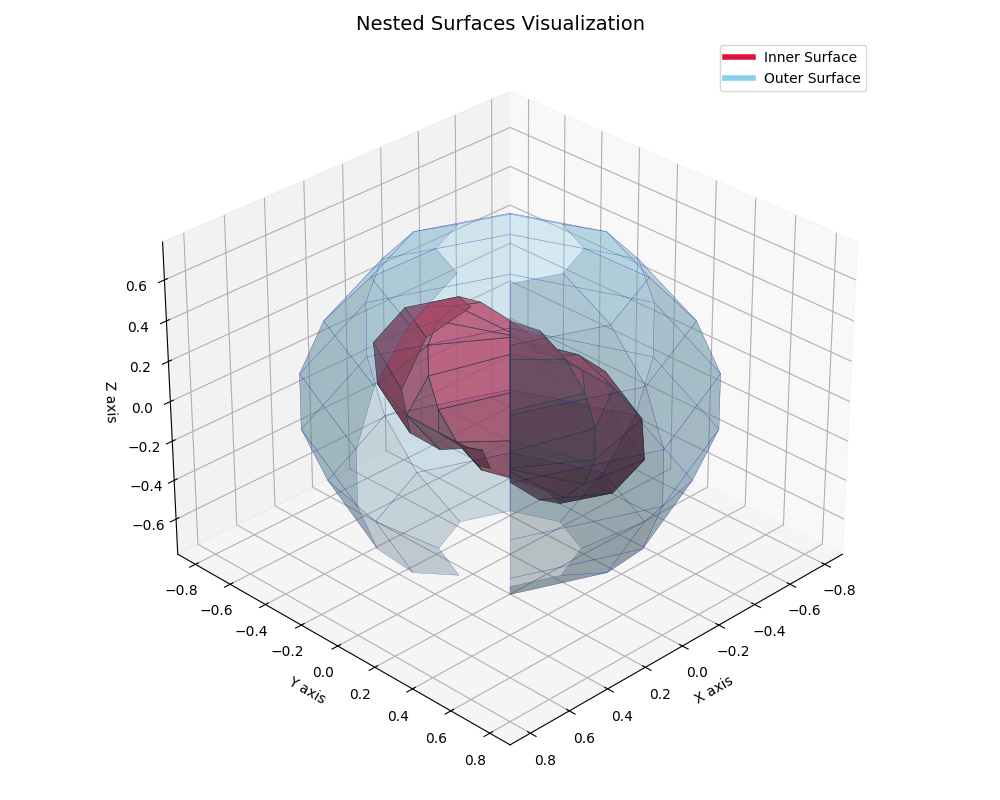

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': 'Nested Surfaces Visualization'}, xlabel='X axis', ylabel='Y axis', zlabel='Z axis'>)

In [18]:
G1_plot = StarlikeSurface.from_radial(mfs_data.collocation, r1)
plot_two_surfaces(G1_plot, Gamma2)

In [19]:
from scipy import integrate

# def calc_l2_norm(ncoll, tn, exact, approx):
#     return np.sqrt(integrate.trapezoid(np.sum((approx-exact)**2, axis=1), tn)*(2*np.pi)/(ncoll))
# def calc_l2_norm(theta_coll, phi_coll, t_coll, exact, approx):
#     vals_reshapred = ((exact-approx)**2).reshape(-1, len(phi_coll), len(theta_coll))

#     # First integrate along the theta direction (axis=2)
#     theta_int = np.trapezoid(vals_reshapred, x=theta_coll, axis=2)

#     # Then integrate the result along phi (axis=1), yielding one value per time slice
#     time_vals = np.trapezoid(theta_int, x=phi_coll, axis=1)

#     # Finally integrate in time using mfs_data.tn as the grid
#     return np.trapezoid(time_vals, x=t_coll)



# def calc_l2_norm(theta_coll, phi_coll, t_coll, exact, approx, approxfunc=None):
#     diff_squared = (exact - approx) ** 2
#     diff_squared = diff_squared.reshape(-1, len(phi_coll), len(theta_coll))
#     # diff_squared = diff_squared.reshape(-1, len(phi_coll), len(theta_coll))
#     mult = (0.8)**2* np.sin(mfs_data.collocation.theta)
#     mult = np.tile(mult, (len(theta_coll), 1))
#     integral_shape = []
#     for ni in range(0, N+1):
#         integral_theta = integrate.trapezoid(diff_squared[ni]*mult, theta_coll)
#         integral_shape.append(integrate.trapezoid(integral_theta, phi_coll))
    
#     # return integrate.trapezoid(integral_shape, t_coll)

#     if approxfunc is None:
#         return integrate.trapezoid(integral_shape, t_coll)
    
#     Theta, Phi = np.meshgrid(theta_coll, phi_coll)
#     approx_vals = approxfunc(Theta, Phi)
#     if np.ndim(approx_vals) == 0:
#         approx_vals = np.full(Theta.shape, approx_vals)
#     return integrate.trapezoid(integral_shape, t_coll) + integrate.trapezoid(integrate.trapezoid(approx_vals**2, theta_coll, axis=0), phi_coll, axis=0)*1e-4

    # return  integrate.trapezoid(integrate.trapezoid(approxfunc(Theta, Phi)**2, theta_coll, axis=0), phi_coll, axis=0)
    # return integrate.trapezoid(integral_shape, t_coll) + integrate.dblquad(lambda theta,phi: approxfunc(theta,phi)**2, 0, np.pi, 0, 2*np.pi)[0]*1e-4

def calc_l2_norm(theta_coll, phi_coll, t_coll, exact, approx, approxfunc=None):
    thetas = np.linspace(0, np.pi, 512)
    phis = np.linspace(0, 2*np.pi, 512)
    Theta, Phi = np.meshgrid(thetas, phis)
    approx_vals = approxfunc(Theta, Phi)
    if np.ndim(approx_vals) == 0:
        approx_vals = np.full(Theta.shape, approx_vals)
    # return np.linalg.norm((exact - approx)**2)
    return np.linalg.norm((exact - approx))**2 + + integrate.trapezoid(integrate.trapezoid(approx_vals**2, thetas, axis=0), phis, axis=0)*1e-4

In [20]:
def feasable(ext_boundary, rfunc, rvals):
    thetas = np.linspace(0, 2*np.pi, 100)

    rvals_start = rfunc(thetas,np.zeros_like(thetas))
    rvals_stop = rfunc(thetas, 2*np.pi*np.ones_like(thetas))

    if not np.allclose(rvals_start, rvals_stop):
        return False
    
    if not np.isfinite(rvals).all():
        return False

    if np.any(np.less(rvals, 0.0)):
        return False

    if np.any(np.greater_equal(rvals, ext_boundary)):
        return False

    return True

def feasable_fine(ext_boundary, rfunc, rvals):
    thetas = np.linspace(0, 2*np.pi, 100)

    rvals_start = rfunc(thetas,np.zeros_like(thetas))
    rvals_stop = rfunc(thetas, 2*np.pi*np.ones_like(thetas))

    if not np.allclose(rvals_start, rvals_stop):
        return 20.0
    
    if not np.isfinite(rvals).all():
        return 1000.0

    if np.any(np.less(rvals, 0.0)):
        return 30.0

    if np.any(np.greater_equal(rvals, ext_boundary)):
        return 500.0
    
    return 0.0

In [21]:
import random
from deap import creator, base, tools, algorithms, gp

In [22]:
import functools
import math, operator

pset = gp.PrimitiveSet("main", 2)
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.cos, 1)
pset.addPrimitive(np.sin, 1)
pset.addPrimitive(np.sqrt, 1)
pset.addEphemeralConstant('rand', (np.random.rand, 1)[0])

pset.renameArguments(ARG0="theta")
pset.renameArguments(ARG1="phi")

In [23]:
import random
from deap import creator, base, tools, algorithms
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [24]:
toolbox = base.Toolbox()
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
# toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=6)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)
# toolbox.register('evaluate', eval_for_g1, Gamma2=Gamma2, Gamma2_source=Gamma2_source, f1=f1, f2=f2, mfs_data=mfs_data)
toolbox.register('feasable', feasable, Gamma2_rvals)
toolbox.register('feasable_fine', feasable_fine, Gamma2_rvals)
# toolbox.register('calc_normals', eval_for_g1, Gamma2, Gamma2_source, matf1, matf2, mfs_data)
toolbox.register('calc_normals', eval_for_g1_optimized, Gamma2, Gamma2_source, matf1, matf2, mfs_data)
toolbox.register('norm', calc_l2_norm, theta_coll=mfs_data.collocation.theta, phi_coll=mfs_data.collocation.phi, t_coll=mfs_data.tn, exact=exact)

toolbox.register('plot', plot_surface)

## Mutation operators

In [25]:
def random_operator(options):
    return random.choice(options)

In [26]:
def cxLinearCombination(ind1, ind2, pset):
    for p in ['multiply', 'add']:
        assert p in pset.mapping, "A '" + p + "' function is required in order to perform semantic crossover"
    index1 = random.randint(0, len(ind1) - 1)
    index2 = random.randint(0, len(ind2) - 1)

    subtree1_slice = ind1.searchSubtree(index1)
    subtree2_slice = ind2.searchSubtree(index2)
    r = random.random()

    tr = gp.PrimitiveTree([])
    tr.insert(0, pset.mapping['multiply'])
    tr.append(gp.Terminal(r, False, object))
    tr.extend(ind1[subtree1_slice])
    tr.insert(0, pset.mapping['add'])
    tr.append(pset.mapping['multiply'])
    tr.append(gp.Terminal(1.0-r, False, object))
    tr.extend(ind2[subtree2_slice])

    ind1[subtree1_slice] = tr
    ind2[subtree2_slice] = tr
    return ind1, ind2


In [27]:
def evaluate(mfsd, tlb, ind):
    # print(ind)
    ind_compile = tlb.compile(expr=ind)
    ind_values = ind_compile(mfsd.collocation.theta_grid, mfsd.collocation.phi_grid)
    # fine  = tlb.feasable_fine(ind_compile, ind_values)

    if not tlb.feasable(ind_compile, ind_values):
        return (1000, )
    # if not tlb.feasable(ind_compile, ind_values):
    #     return (1e6, )

    g2_approx = tlb.calc_normals(ind_compile)
    if g2_approx is None:
        return (1000, )
    return (toolbox.norm(approx=g2_approx, approxfunc=ind_compile), )
    # try:
    #     return (toolbox.norm(approx=g2_approx, approxfunc=ind_compile), )
    # except Exception as e:
    #     print(f"Error during integration: {e},\n for approxfunc: {str(ind)}")
    #     raise Exception("Integration failed. Please check the input data or the integration method.")

# def evaluate(mfsd, tlb, ind):
#     # print(ind)
#     ind_compile = tlb.compile(expr=ind)
#     ind_values = ind_compile(mfsd.collocation.theta_grid, mfsd.collocation.phi_grid)
#     if not tlb.feasable(ind_compile, ind_values):
#         return (1000, )
#     # if not tlb.feasable(ind_compile, ind_values):
#     #     return (1e6, )

#     g2_approx = tlb.calc_normals(ind_compile)
#     if g2_approx is None:
#         return (1000, )
#     return (toolbox.norm(g2_approx), )
toolbox.register('evaluate', evaluate, mfs_data, toolbox)

toolbox.register("select", tools.selTournament, tournsize=3)
# toolbox.register("select", tools.selDoubleTournament, fitness_size=3, fitness_first=True, parsimony_size=1.4)

toolbox.register("mate_onepoint", gp.cxOnePoint)
toolbox.register("mate_lincomb", cxLinearCombination, pset=pset)
toolbox.register("mate_leaf_based", gp.cxOnePointLeafBiased, termpb=0.35)
mate_operators = [toolbox.mate_lincomb, toolbox.mate_onepoint, toolbox.mate_leaf_based]

toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=3)
toolbox.register("mutate_uniform", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("mutate_node_replacement", gp.mutNodeReplacement, pset=pset)
toolbox.register("mutate_ephemeral", gp.mutEphemeral, mode="one")
toolbox.register("mutate_insert", gp.mutInsert, pset=pset)
toolbox.register("mutate_shrink", gp.mutShrink)
# mutate_operators = [toolbox.mutate_uniform, toolbox.mutate_node_replacement, toolbox.mutate_ephemeral, toolbox.mutate_insert, toolbox.mutate_shrink]
mutate_operators = [toolbox.mutate_uniform, toolbox.mutate_ephemeral]


toolbox.register("mate", random.choice(mate_operators))
toolbox.register("mutate", random.choice(mutate_operators))



# toolbox.register("mate", gp.cxOnePointLeafBiased, termpb=0.4)
# toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=2)
# toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))
# toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))


In [28]:
pop = toolbox.population(n=50)
# pop[0] = creator.Individual(gp.PrimitiveTree.from_string(
#                 'multiply(sin(cos(cos(add(sin(cos(phi)), theta)))), sin(cos(multiply(sin(phi), cos(multiply(cos(multiply(multiply(sin(multiply(cos(add(add(cos(phi), theta), theta)), multiply(cos(add(theta, theta)), cos(add(cos(phi), theta))))), cos(add(theta, theta))), add(theta, cos(sin(multiply(cos(add(add(add(cos(theta), theta), theta), theta)), multiply(cos(add(theta, theta)), cos(add(cos(theta), theta))))))))), multiply(add(sin(cos(phi)), cos(phi)), cos(phi))))))))',
#                 pset=pset))
# pop[1] = creator.Individual(gp.PrimitiveTree.from_string(
#                 'multiply(sin(cos(cos(add(sin(cos(phi)), cos(theta))))), sin(cos(multiply(sin(phi), cos(multiply(cos(multiply(multiply(sin(multiply(cos(add(add(add(phi, phi), theta), theta)), multiply(cos(add(theta, theta)), cos(add(cos(phi), theta))))), cos(add(theta, theta))), add(theta, cos(sin(multiply(cos(add(add(add(cos(theta), theta), theta), theta)), multiply(theta, cos(add(cos(sin(theta)), theta))))))))), multiply(add(sin(cos(phi)), cos(phi)), cos(phi))))))))',
#                 pset=pset))
# pop[1] = creator.Individual(gp.PrimitiveTree.from_string(
#                 'sin(cos(cos(multiply(multiply(sin(phi), multiply(sin(phi), cos(theta))), sin(theta)))))',
#                 pset=pset))
# pop[1] = creator.Individual(gp.PrimitiveTree.from_string(
#                 'multiply(cos(cos(add(cos(phi), sin(cos(theta))))), 0.5645709092800931)',
#                 pset=pset))
pop[1] = creator.Individual(gp.PrimitiveTree.from_string(
                'multiply(sin(cos(cos(add(sin(multiply(sin(add(add(multiply(0.21192242597370525, multiply(0.9905964180780163, add(multiply(add(multiply(0.3834179189665434, 0.898585144883628), multiply(0.6165820810334566, 0.9905964180780163)), cos(phi)), multiply(add(multiply(0.8772313699045681, 0.10141485511637205), multiply(0.12276863009543193, multiply(0.10484875618115885, theta))), multiply(0.21192242597370525, multiply(0.9905964180780163, cos(phi))))))), multiply(add(multiply(0.9425577550563142, add(multiply(0.23562329650654223, 0.7880775740262947), multiply(0.7643767034934578, 0.755749427346623))), multiply(0.05744224494368577, multiply(0.8662764536726794, multiply(0.8520939473196918, 0.7791484662536328)))), add(multiply(0.9905964180780163, cos(phi)), multiply(0.00940358192198365, add(add(multiply(0.09344001712687822, multiply(0.0022126737391604534, theta)), multiply(0.9065599828731218, theta)), multiply(add(multiply(0.8038791783004209, 0.9977873262608395), multiply(0.19612082169957912, theta)), add(multiply(0.768939984138935, theta), multiply(0.23106001586106495, theta)))))))), multiply(add(multiply(add(multiply(0.303562061492623, 0.6272180521200783), multiply(0.696437938507377, add(multiply(0.367356919011681, theta), multiply(0.632643080988319, theta)))), 0.00940358192198365), multiply(add(multiply(0.7715189766655002, add(multiply(0.5286544962747985, 0.3727819478799217), multiply(0.47134550372520145, multiply(0.19612082169957912, theta)))), multiply(0.22848102333449982, 0.755749427346623)), multiply(0.00940358192198365, theta))), add(multiply(0.6442580975273984, add(multiply(0.42894401137418503, theta), multiply(0.571055988625815, multiply(0.9905964180780163, cos(phi))))), multiply(0.3557419024726016, multiply(0.7180995352973719, add(multiply(0.4509406324800941, 0.04277635924466794), add(multiply(0.5278606996585422, multiply(0.5490593675199059, theta)), multiply(0.4721393003414578, multiply(0.020990827482159857, 0.9496450572441838)))))))))), cos(add(multiply(add(multiply(0.641179363533605, add(multiply(0.6086583031935879, 0.8848348910394339), multiply(0.39134169680641206, add(multiply(0.7852083843382952, 0.3557419024726016), multiply(0.2147916156617048, cos(theta)))))), add(multiply(add(add(multiply(0.8662764536726794, multiply(0.8520939473196918, 0.7791484662536328)), multiply(0.13372354632732064, 0.3834179189665434)), multiply(add(multiply(0.28431659064078174, 0.1479060526803082), multiply(0.7156834093592183, 0.9065599828731218)), cos(phi))), multiply(0.35882063646639495, 0.9527104877528322)), multiply(0.22085153374636723, multiply(0.5359300349875976, cos(phi))))), 0.3565927472986107), multiply(0.11516510896056609, add(add(multiply(add(multiply(0.10933197044981247, 0.688341330295813), multiply(0.8906680295501875, 0.9496450572441838)), multiply(add(multiply(0.3461432540240541, 0.7924460479298142), multiply(0.6538567459759459, 0.8848348910394339)), cos(phi))), multiply(0.311658669704187, 0.47134550372520145)), multiply(0.2075539520701858, add(multiply(0.7231462536286856, sin(cos(phi))), multiply(add(multiply(0.8248729928086413, 0.27685374637131444), multiply(0.17512700719135865, theta)), add(multiply(0.5510346367056798, cos(theta)), multiply(0.44896536329432024, 0.5359300349875976))))))))))), theta)))), sin(cos(multiply(add(add(add(multiply(0.931783555835036, multiply(0.9963032422687391, multiply(0.9790091725178401, add(multiply(0.9560818168622379, sin(theta)), multiply(0.04391818313776208, add(multiply(0.12801684183047768, 0.8772313699045681), multiply(0.8719831581695223, 0.9905964180780163))))))), multiply(0.06821644416496397, 0.755749427346623)), multiply(0.00369675773126088, add(multiply(0.2389605337596603, add(add(multiply(0.14025235488738275, multiply(0.8662764536726794, multiply(0.8520939473196918, 0.7791484662536328))), multiply(0.8597476451126173, 0.8662764536726794)), add(multiply(0.29974059681140575, multiply(0.13372354632732064, 0.3834179189665434)), multiply(0.7002594031885943, 0.20158499083661718)))), add(multiply(0.03073760344942733, multiply(0.7610394662403397, multiply(0.13081286623781518, add(multiply(0.5235009328280223, add(multiply(0.4509406324800941, 0.04277635924466794), multiply(0.5490593675199059, theta))), multiply(0.47649906717197765, 0.9527104877528322))))), multiply(0.9692623965505727, multiply(0.42894401137418503, theta)))))), multiply(0.020990827482159857, 0.9496450572441838)), cos(multiply(cos(multiply(multiply(sin(add(multiply(0.8951512438188411, theta), multiply(0.10484875618115885, theta))), cos(multiply(cos(add(add(multiply(0.33384883606372295, multiply(0.37820007773848097, 0.755749427346623)), multiply(0.666151163936277, 0.6442580975273984)), multiply(add(multiply(0.3309156811506815, 0.621799922261519), multiply(0.6690843188493185, theta)), multiply(0.10484875618115885, theta)))), sin(sin(cos(sin(sqrt(sqrt(0.9918875967811362))))))))), cos(multiply(add(multiply(add(multiply(0.9572236407553321, add(multiply(0.545913088948782, 0.9311376803791309), multiply(0.454086911051218, 0.9905964180780163))), multiply(add(multiply(0.7180995352973719, 0.04277635924466794), multiply(0.2819004647026281, 0.21601435291634186)), add(multiply(0.9905964180780163, cos(phi)), multiply(0.00940358192198365, theta)))), cos(theta)), multiply(add(multiply(0.8335839391235736, 0.06886231962086908), multiply(add(multiply(0.9018380712854206, 0.16641606087642635), multiply(0.0981619287145794, 0.47134550372520145)), add(multiply(0.9165417162882901, 0.755749427346623), multiply(0.08345828371170994, 0.5359300349875976)))), sin(add(multiply(0.9905964180780163, cos(phi)), add(multiply(0.9527104877528322, multiply(0.00940358192198365, theta)), multiply(0.04728951224716782, cos(0.755749427346623))))))), multiply(theta, multiply(add(multiply(0.7231462536286856, sin(cos(phi))), multiply(add(multiply(0.8248729928086413, 0.27685374637131444), multiply(0.17512700719135865, theta)), cos(theta))), multiply(add(add(multiply(0.4640699650124024, sqrt(0.21601435291634186)), multiply(0.5359300349875976, cos(phi))), add(0.7842815844976379, theta)), sin(phi)))))))), multiply(sin(theta), add(add(multiply(0.7984150091633828, multiply(0.5057755476424941, cos(phi))), multiply(add(multiply(0.9496450572441838, add(multiply(0.6676651806624374, add(multiply(0.9258800512497317, 0.20158499083661718), multiply(0.07411994875026828, multiply(0.8906680295501875, 0.9496450572441838)))), multiply(0.3323348193375626, multiply(0.35882063646639495, 0.9527104877528322)))), add(multiply(0.8916609367387508, multiply(0.0503549427558162, sqrt(sqrt(0.9918875967811362)))), multiply(add(multiply(0.8372843492041192, 0.1083390632612492), multiply(0.1627156507958808, 0.9496450572441838)), 0.303562061492623))), cos(theta))), multiply(0.4942244523575059, multiply(0.9905964180780163, cos(phi)))))))))))',
                pset=pset))
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# pop, log = algorithms.eaSimple(pop, toolbox, 0.6, 0.2, 50, stats=mstats,
#                             halloffame=hof, verbose=True)
# pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats,
#                             halloffame=hof, verbose=True)

# MU, LAMBDA = 100, 200
# pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
#                                             cxpb=0.7, mutpb=0.3, ngen=40, 
#                                             stats=mstats, halloffame=hof)

## Similar to R-model
# MU, LAMBDA = 300, 200
# pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
#                                             cxpb=0.7, mutpb=0.3, ngen=40, 
#                                             stats=mstats, halloffame=hof)

MU, LAMBDA = 100, 200
# MU, LAMBDA = 200, 400
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
                                            cxpb=0.7, mutpb=0.3, ngen=300, 
                                            stats=mstats, halloffame=hof)

<string>:1: RuntimeWarning: invalid value encountered in sqrt


   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std    	avg  	gen	max	min	nevals	std    
0  	50    	1002.91	0  	1664.05	3.86343	50    	257.744	14.64	0  	548	2  	50    	76.2243
1  	200   	863.003	1  	1000   	19.6698	200   	273.845	25.12	1  	549	1  	200   	105.23 
2  	200   	761.531	2  	1000   	19.6698	200   	322.571	41.02	2  	549	1  	200   	136.024
3  	200   	666.297	3  	1000   	14.1643	200   	384.085	118.74	3  	548	1  	200   	216.442
4  	200   	453.908	4  	1000   	14.0759	200   	407.185	238.62	4  	548	1  	200   	255.1  
5  	200   	196.217	5  	1000   	12.783 	200   	315.443	423.34	5  	549	2  	200   	197.894
6  	200   	63.2459	6  	1000   	9.23002	200   	148.398	496.15	6  	548	5  	200   	88.9452
7  	200   	21.1482	7  	431.528	9.23002	200   	42.0585	505.81	7  	536	463	200   	18.897

KeyboardInterrupt: 

In [ ]:
print(hof[0])

sin(add(add(multiply(0.7733757342219791, multiply(add(multiply(0.017740465439605835, 0.9160938283501789), multiply(0.9822595345603942, 0.8672510503287656)), add(multiply(0.2622437091059827, cos(sin(theta))), multiply(0.7377562908940173, sqrt(sin(0.30444566416102714)))))), multiply(0.22662426577802086, multiply(0.6303102315078242, cos(sin(sin(phi)))))), multiply(0.08390617164982106, add(multiply(0.9473126452896128, multiply(add(multiply(0.3902224221910733, add(multiply(0.8646990738701841, 0.7243462499716256), multiply(0.13530092612981592, cos(theta)))), multiply(0.6097775778089267, 0.6604550490868585)), multiply(0.14787690263607067, sqrt(0.21119780934820798)))), multiply(0.05268735471038721, 0.36968976849217583)))))


In [ ]:
indstr = "multiply(sin(sin(cos(cos(add(sin(cos(phi)), theta))))), sin(cos(multiply(cos(multiply(add(sin(cos(phi)), cos(theta)), cos(multiply(sin(phi), cos(multiply(cos(multiply(cos(add(sin(cos(phi)), theta)), add(theta, 0.030366745273640028))), cos(multiply(phi, add(theta, 0.24316375853435201))))))))), cos(multiply(add(cos(phi), cos(theta)), cos(phi)))))))"
ind = creator.Individual(gp.PrimitiveTree.from_string(indstr, pset=pset))

In [ ]:
approxfunc = toolbox.compile(expr=ind)
Theta, Phi = np.meshgrid(mfs_data.collocation.theta, mfs_data.collocation.phi)
integrate.trapezoid(integrate.trapezoid(approxfunc(Theta, Phi)**2, mfs_data.collocation.theta, axis=0), mfs_data.collocation.phi, axis=0)

np.float64(2.6241507051878488)

In [ ]:
for ind in pop:
    print(ind, ind.fitness.values)

multiply(sin(cos(cos(add(sin(multiply(sin(add(add(multiply(0.21192242597370525, multiply(0.9905964180780163, add(multiply(add(multiply(0.3834179189665434, 0.898585144883628), multiply(0.6165820810334566, 0.9905964180780163)), cos(phi)), multiply(add(multiply(0.8772313699045681, 0.10141485511637205), multiply(0.12276863009543193, multiply(0.10484875618115885, theta))), multiply(0.21192242597370525, multiply(0.9905964180780163, cos(phi))))))), multiply(add(multiply(0.9425577550563142, add(multiply(0.23562329650654223, 0.7880775740262947), multiply(0.7643767034934578, 0.755749427346623))), multiply(0.05744224494368577, multiply(0.8662764536726794, multiply(0.8520939473196918, 0.7791484662536328)))), add(multiply(0.9905964180780163, cos(phi)), multiply(0.00940358192198365, add(add(multiply(0.09344001712687822, multiply(0.0022126737391604534, theta)), multiply(0.9065599828731218, theta)), multiply(add(multiply(0.8038791783004209, 0.9977873262608395), multiply(0.19612082169957912, theta)), a

In [29]:
# def plot_approx_and_exact(exact_solution, approx_solution):
#     """
#     Plot exact and approximated solutions with error visualization.
    
#     Parameters:
#     - exact_solution: StarlikeSurface object representing the exact solution
#     - approx_solution: StarlikeSurface object representing the approximated solution
#     """
#     # Create a figure with three subplots - side, top, error
#     fig = plt.figure(figsize=(18, 6))
    
#     # First subplot: Side-by-side comparison
#     ax1 = fig.add_subplot(131, projection='3d')

#     # Extract data for exact solution
#     theta_grid = np.linspace(0, np.pi, 512)
#     phi_grid = np.linspace(0, 2 * np.pi, 512)    
    
#     # Extract data for exact solution
#     theta_grid = exact_solution.collocation.theta_grid
#     phi_grid = exact_solution.collocation.phi_grid
    
#     # Exact solution (left half)
#     rvals_exact = exact_solution.rf(theta_grid, phi_grid)
#     x_exact = rvals_exact * np.sin(theta_grid) * np.cos(phi_grid)
#     y_exact = rvals_exact * np.sin(theta_grid) * np.sin(phi_grid)
#     z_exact = rvals_exact * np.cos(theta_grid)
    
#     # Approximate solution (right half)
#     rvals_approx = approx_solution.rf(theta_grid, phi_grid)
#     x_approx = rvals_approx * np.sin(theta_grid) * np.cos(phi_grid)
#     y_approx = rvals_approx * np.sin(theta_grid) * np.sin(phi_grid)
#     z_approx = rvals_approx * np.cos(theta_grid)
    
#     # Compute the difference/error between surfaces
#     diff = np.abs(rvals_exact - rvals_approx)
#     max_diff = np.max(diff)
    
#     # Plot exact solution
#     surf_exact = ax1.plot_surface(x_exact, y_exact, z_exact, 
#                                  color='green', alpha=0.7,
#                                  label='Exact')
    
#     # Plot approximate solution
#     surf_approx = ax1.plot_surface(x_approx, y_approx, z_approx, 
#                                   color='red', alpha=0.3,
#                                   label='Approximation')
    
#     ax1.set_title('Exact vs Approximate Solutions')
#     ax1.set_xlabel('X')
#     ax1.set_ylabel('Y')
#     ax1.set_zlabel('Z')
    
#     # Second subplot: Overlay with color-mapped error
#     ax2 = fig.add_subplot(132, projection='3d')
    
#     # Plot exact solution as wireframe for reference
#     ax2.plot_wireframe(x_exact, y_exact, z_exact, 
#                       color='black', alpha=0.3, linewidth=0.5)
    
#     # Plot approximate solution with error-based colormapping
#     norm = plt.Normalize(0, max_diff)
#     surf_error = ax2.plot_surface(x_approx, y_approx, z_approx, 
#                                  facecolors=plt.cm.jet(norm(diff)),
#                                  alpha=0.8)
    
#     # Add a colorbar
#     cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet), 
#                        ax=ax2, shrink=0.6, aspect=10)
#     cbar.set_label('Absolute Error')
    
#     ax2.set_title('Error Distribution')
#     ax2.set_xlabel('X')
#     ax2.set_ylabel('Y')
#     ax2.set_zlabel('Z')
    
#     # Third subplot: 2D Error Heatmap (unwrapped view)
#     ax3 = fig.add_subplot(133)
    
#     # Create a 2D heatmap of the error
#     im = ax3.pcolormesh(phi_grid, theta_grid, diff, cmap='jet', shading='auto')
#     cbar2 = fig.colorbar(im, ax=ax3)
#     cbar2.set_label('Absolute Error')
    
#     ax3.set_title('Unwrapped Error Distribution')
#     ax3.set_xlabel('φ (Phi)')
#     ax3.set_ylabel('θ (Theta)')
    
#     # Set consistent view angles
#     ax1.view_init(elev=30, azim=45)
#     ax2.view_init(elev=30, azim=45)
    
#     # Create a custom legend for the first subplot
#     from matplotlib.lines import Line2D
#     legend_elements = [
#         Line2D([0], [0], color='green', lw=4, label='Exact Solution'),
#         Line2D([0], [0], color='red', lw=4, label='Approximation')
#     ]
#     ax1.legend(handles=legend_elements, loc='upper right')
    
#     plt.tight_layout()
#     return fig, (ax1, ax2, ax3)
def plot_approx_and_exact(rexact, rapprox):
    """
    Plot exact and approximated solutions with error visualization.
    
    Parameters:
    - exact_solution: StarlikeSurface object representing the exact solution
    - approx_solution: StarlikeSurface object representing the approximated solution
    """
    # Create a figure with three subplots - side, top, error
    fig = plt.figure(figsize=(18, 6))
    
    # First subplot: Side-by-side comparison
    ax1 = fig.add_subplot(131, projection='3d')

    # Extract data for exact solution
    thetas = np.linspace(0, np.pi, 512)
    phis = np.linspace(0, 2 * np.pi, 512)

    theta_grid, phi_grid = np.meshgrid(thetas, phis)
    # theta_grid = np.linspace(0, np.pi, 512)
    # phi_grid = np.linspace(0, 2 * np.pi, 512)
    
    # Exact solution (left half)
    rvals_exact = rexact(theta_grid, phi_grid)
    x_exact = rvals_exact * np.sin(theta_grid) * np.cos(phi_grid)
    y_exact = rvals_exact * np.sin(theta_grid) * np.sin(phi_grid)
    z_exact = rvals_exact * np.cos(theta_grid)
    
    # Approximate solution (right half)
    rvals_approx = rapprox(theta_grid, phi_grid)
    x_approx = rvals_approx * np.sin(theta_grid) * np.cos(phi_grid)
    y_approx = rvals_approx * np.sin(theta_grid) * np.sin(phi_grid)
    z_approx = rvals_approx * np.cos(theta_grid)
    
    # Compute the difference/error between surfaces
    diff = np.abs(rvals_exact - rvals_approx)
    max_diff = np.max(diff)
    
    # Plot exact solution
    surf_exact = ax1.plot_surface(x_exact, y_exact, z_exact, 
                                 color='green', alpha=0.7,
                                 label='Exact')
    
    # Plot approximate solution
    surf_approx = ax1.plot_surface(x_approx, y_approx, z_approx, 
                                  color='red', alpha=0.3,
                                  label='Approximation')
    
    ax1.set_title('Exact vs Approximate Solutions')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # Second subplot: Overlay with color-mapped error
    ax2 = fig.add_subplot(132, projection='3d')
    
    # Plot exact solution as wireframe for reference
    ax2.plot_wireframe(x_exact, y_exact, z_exact, 
                      color='black', alpha=0.3, linewidth=0.5)
    
    # Plot approximate solution with error-based colormapping
    norm = plt.Normalize(0, max_diff)
    surf_error = ax2.plot_surface(x_approx, y_approx, z_approx, 
                                 facecolors=plt.cm.jet(norm(diff)),
                                 alpha=0.8)
    
    # Add a colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet), 
                       ax=ax2, shrink=0.6, aspect=10)
    cbar.set_label('Absolute Error')
    
    ax2.set_title('Error Distribution')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    # Third subplot: 2D Error Heatmap (unwrapped view)
    ax3 = fig.add_subplot(133)
    
    # Create a 2D heatmap of the error
    im = ax3.pcolormesh(phi_grid, theta_grid, diff, cmap='jet', shading='auto')
    cbar2 = fig.colorbar(im, ax=ax3)
    cbar2.set_label('Absolute Error')
    
    ax3.set_title('Unwrapped Error Distribution')
    ax3.set_xlabel('φ (Phi)')
    ax3.set_ylabel('θ (Theta)')
    
    # Set consistent view angles
    ax1.view_init(elev=30, azim=45)
    ax2.view_init(elev=30, azim=45)
    
    # Create a custom legend for the first subplot
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='green', lw=4, label='Exact Solution'),
        Line2D([0], [0], color='red', lw=4, label='Approximation')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    return fig, (ax1, ax2, ax3)

(<Figure size 1800x600 with 5 Axes>,
 (<Axes3D: title={'center': 'Exact vs Approximate Solutions'}, xlabel='X', ylabel='Y', zlabel='Z'>,
  <Axes3D: title={'center': 'Error Distribution'}, xlabel='X', ylabel='Y', zlabel='Z'>,
  <Axes: title={'center': 'Unwrapped Error Distribution'}, xlabel='φ (Phi)', ylabel='θ (Theta)'>))

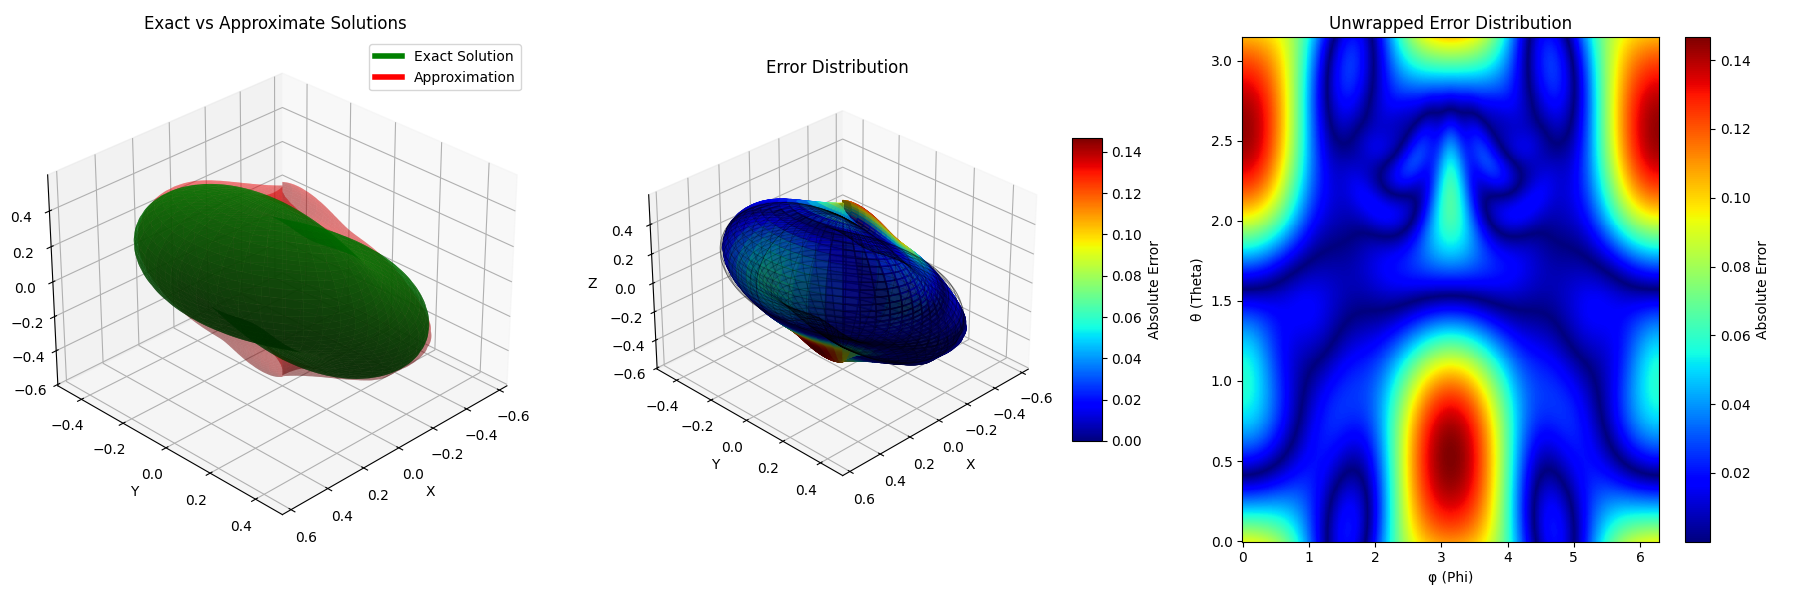

In [30]:

# G1_plot_exact = StarlikeSurface.from_radial(mfs_data.collocation, r1)
# G1_plot_approx = StarlikeSurface.from_radial(mfs_data.collocation, toolbox.compile(expr=hof[0]))
# plot_approx_and_exact(G1_plot_exact, G1_plot_approx)
plot_approx_and_exact(r1, toolbox.compile(expr=hof[0]))
# plot_approx_and_exact(r1, toolbox.compile(expr=ind))

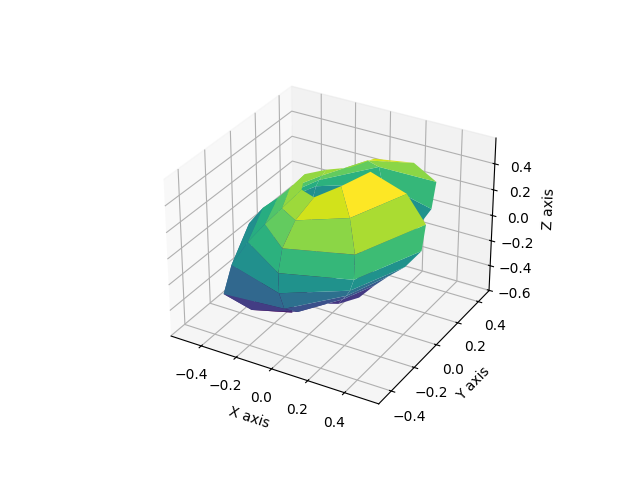

In [ ]:
G1_test = StarlikeSurface.from_radial(mfs_data.collocation, toolbox.compile(expr=hof[0]))
toolbox.plot(G1_test)

In [ ]:
# rapprox = toolbox.compile(expr=ind)
rapprox = toolbox.compile(expr=hof[0])
enum = integrate.dblquad(lambda theta, phi: (r1(theta, phi) - rapprox(theta, phi)) ** 2, 0, np.pi, 0, 2*np.pi)
den = integrate.dblquad(lambda theta, phi: (r1(theta, phi)) ** 2, 0, np.pi, 0, 2*np.pi)
print("L2 norm: ", np.sqrt(enum[0]/den[0]))

/Users/armarche/.pyenv/versions/3.12.6/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


L2 norm:  0.206472367296631


In [ ]:
assert False

AssertionError: 

In [ ]:
Gamma2.mesh.shape

(3, 16, 16)

In [ ]:
Gamma2.mesh

array([[[ 1.35809935e-01,  2.66995025e-01,  3.89087920e-01,
          4.97930893e-01,  5.89817426e-01,  6.61618435e-01,
          7.10888820e-01,  7.35950740e-01,  7.35950740e-01,
          7.10888820e-01,  6.61618435e-01,  5.89817426e-01,
          4.97930893e-01,  3.89087920e-01,  2.66995025e-01,
          1.35809935e-01],
        [ 1.03944424e-01,  2.04349145e-01,  2.97795002e-01,
          3.81099806e-01,  4.51426714e-01,  5.06380827e-01,
          5.44090748e-01,  5.63272311e-01,  5.63272311e-01,
          5.44090748e-01,  5.06380827e-01,  4.51426714e-01,
          3.81099806e-01,  2.97795002e-01,  2.04349145e-01,
          1.03944424e-01],
        [ 5.62543169e-02,  1.10592961e-01,  1.61165494e-01,
          2.06249729e-01,  2.44310377e-01,  2.74051329e-01,
          2.94459791e-01,  3.04840778e-01,  3.04840778e-01,
          2.94459791e-01,  2.74051329e-01,  2.44310377e-01,
          2.06249729e-01,  1.61165494e-01,  1.10592961e-01,
          5.62543169e-02],
        [ 9.0011303

In [ ]:
np.allclose(Gamma2.mesh.reshape(3,16,16), Gamma2.mesh)


True

In [ ]:
Gamma2.mesh.reshape(3,16,16)

In [ ]:
exact[0]

array([4.41494844, 4.229262  , 3.86122678, 3.53586801, 3.38152192,
       3.3773244 , 3.49900817, 3.779525  , 4.20972172, 4.66962528,
       4.95934551, 4.90759054, 4.57198809, 4.16916184, 3.82321994,
       3.53404234, 4.41494844, 4.229262  , 3.86122678, 3.53586801,
       3.38152192, 3.3773244 , 3.49900817, 3.779525  , 4.20972172,
       4.66962528, 4.95934551, 4.90759054, 4.57198809, 4.16916184,
       3.82321994, 3.53404234, 4.41494844, 4.229262  , 3.86122678,
       3.53586801, 3.38152192, 3.3773244 , 3.49900817, 3.779525  ,
       4.20972172, 4.66962528, 4.95934551, 4.90759054, 4.57198809,
       4.16916184, 3.82321994, 3.53404234, 4.41494844, 4.229262  ,
       3.86122678, 3.53586801, 3.38152192, 3.3773244 , 3.49900817,
       3.779525  , 4.20972172, 4.66962528, 4.95934551, 4.90759054,
       4.57198809, 4.16916184, 3.82321994, 3.53404234, 4.41494844,
       4.229262  , 3.86122678, 3.53586801, 3.38152192, 3.3773244 ,
       3.49900817, 3.779525  , 4.20972172, 4.66962528, 4.95934

In [ ]:
exact[0].reshape(16,16)


array([[4.41494844, 4.229262  , 3.86122678, 3.53586801, 3.38152192,
        3.3773244 , 3.49900817, 3.779525  , 4.20972172, 4.66962528,
        4.95934551, 4.90759054, 4.57198809, 4.16916184, 3.82321994,
        3.53404234],
       [4.41494844, 4.229262  , 3.86122678, 3.53586801, 3.38152192,
        3.3773244 , 3.49900817, 3.779525  , 4.20972172, 4.66962528,
        4.95934551, 4.90759054, 4.57198809, 4.16916184, 3.82321994,
        3.53404234],
       [4.41494844, 4.229262  , 3.86122678, 3.53586801, 3.38152192,
        3.3773244 , 3.49900817, 3.779525  , 4.20972172, 4.66962528,
        4.95934551, 4.90759054, 4.57198809, 4.16916184, 3.82321994,
        3.53404234],
       [4.41494844, 4.229262  , 3.86122678, 3.53586801, 3.38152192,
        3.3773244 , 3.49900817, 3.779525  , 4.20972172, 4.66962528,
        4.95934551, 4.90759054, 4.57198809, 4.16916184, 3.82321994,
        3.53404234],
       [4.41494844, 4.229262  , 3.86122678, 3.53586801, 3.38152192,
        3.3773244 , 3.49900817, 

In [ ]:
exact_reshaped = exact[0].reshape(16,16)

In [ ]:
mult = (0.8)**2* np.sin(mfs_data.collocation.theta)
mult

array([0.11759969, 0.23119467, 0.33691658, 0.43116521, 0.51073103,
       0.57290451, 0.61556841, 0.63726987, 0.63726987, 0.61556841,
       0.57290451, 0.51073103, 0.43116521, 0.33691658, 0.23119467,
       0.11759969])

In [ ]:
np.tile(mult, (16, 1))

array([[0.11759969, 0.23119467, 0.33691658, 0.43116521, 0.51073103,
        0.57290451, 0.61556841, 0.63726987, 0.63726987, 0.61556841,
        0.57290451, 0.51073103, 0.43116521, 0.33691658, 0.23119467,
        0.11759969],
       [0.11759969, 0.23119467, 0.33691658, 0.43116521, 0.51073103,
        0.57290451, 0.61556841, 0.63726987, 0.63726987, 0.61556841,
        0.57290451, 0.51073103, 0.43116521, 0.33691658, 0.23119467,
        0.11759969],
       [0.11759969, 0.23119467, 0.33691658, 0.43116521, 0.51073103,
        0.57290451, 0.61556841, 0.63726987, 0.63726987, 0.61556841,
        0.57290451, 0.51073103, 0.43116521, 0.33691658, 0.23119467,
        0.11759969],
       [0.11759969, 0.23119467, 0.33691658, 0.43116521, 0.51073103,
        0.57290451, 0.61556841, 0.63726987, 0.63726987, 0.61556841,
        0.57290451, 0.51073103, 0.43116521, 0.33691658, 0.23119467,
        0.11759969],
       [0.11759969, 0.23119467, 0.33691658, 0.43116521, 0.51073103,
        0.57290451, 0.61556841, 

In [ ]:
integrate.trapezoid(exact_reshaped[0]*mult, Gamma2.collocation.theta)

np.float64(5.111513273561904)

In [ ]:
integral_theta = integrate.trapezoid(exact_reshaped*np.tile(mult, (16, 1)), Gamma2.collocation.theta)

In [ ]:
integrate.trapezoid(integral_theta, Gamma2.collocation.phi)

np.float64(30.109298529279158)

In [ ]:
exact.shape

(8, 256)

In [ ]:
exact_reshaped = exact.reshape(8, 16,16)

In [ ]:
np.allclose(exact.reshape(8, 16,16),exact.reshape(-1, 16,16))

True

In [ ]:
exact.reshape(-1, 16,16)

array([[[4.41494844, 4.229262  , 3.86122678, ..., 4.16916184,
         3.82321994, 3.53404234],
        [4.41494844, 4.229262  , 3.86122678, ..., 4.16916184,
         3.82321994, 3.53404234],
        [4.41494844, 4.229262  , 3.86122678, ..., 4.16916184,
         3.82321994, 3.53404234],
        ...,
        [4.41494844, 4.229262  , 3.86122678, ..., 4.16916184,
         3.82321994, 3.53404234],
        [4.41494844, 4.229262  , 3.86122678, ..., 4.16916184,
         3.82321994, 3.53404234],
        [4.41494844, 4.229262  , 3.86122678, ..., 4.16916184,
         3.82321994, 3.53404234]],

       [[2.43474706, 1.88270285, 1.32868291, ..., 1.84859687,
         1.22030343, 0.9420278 ],
        [2.43474706, 1.88270285, 1.32868291, ..., 1.84859687,
         1.22030343, 0.9420278 ],
        [2.43474706, 1.88270285, 1.32868291, ..., 1.84859687,
         1.22030343, 0.9420278 ],
        ...,
        [2.43474706, 1.88270285, 1.32868291, ..., 1.84859687,
         1.22030343, 0.9420278 ],
        [2.4

In [ ]:
mult = (0.8)**2* np.sin(mfs_data.collocation.theta)
mult = np.tile(mult, (16, 1))
integral_shape = []
for ni in range(0, N+1):
    integral_theta = integrate.trapezoid(exact_reshaped[ni]*mult, Gamma2.collocation.theta)
    integral_phi = integrate.trapezoid(integral_theta, Gamma2.collocation.phi)
    integral_shape.append(integral_phi)
    print(integral_phi)
integrate.trapezoid(integral_shape, mfs_data.tn)

30.10929852927898
30.109298529278348
30.109298529280775
30.109298529277357
30.10929852928161
30.109298529276312
30.109298529281805
30.109298529276824


In [ ]:
integrate.trapezoid(integral_shape, mfs_data.tn)

np.float64(26.345636213119263)

In [ ]:
Gamma2.collocation.theta

array([0.18479957, 0.36959914, 0.5543987 , 0.73919827, 0.92399784,
       1.10879741, 1.29359698, 1.47839654, 1.66319611, 1.84799568,
       2.03279525, 2.21759481, 2.40239438, 2.58719395, 2.77199352,
       2.95679309])

In [ ]:
Gamma2.collocation.theta_grid

array([[0.18479957, 0.36959914, 0.5543987 , 0.73919827, 0.92399784,
        1.10879741, 1.29359698, 1.47839654, 1.66319611, 1.84799568,
        2.03279525, 2.21759481, 2.40239438, 2.58719395, 2.77199352,
        2.95679309],
       [0.18479957, 0.36959914, 0.5543987 , 0.73919827, 0.92399784,
        1.10879741, 1.29359698, 1.47839654, 1.66319611, 1.84799568,
        2.03279525, 2.21759481, 2.40239438, 2.58719395, 2.77199352,
        2.95679309],
       [0.18479957, 0.36959914, 0.5543987 , 0.73919827, 0.92399784,
        1.10879741, 1.29359698, 1.47839654, 1.66319611, 1.84799568,
        2.03279525, 2.21759481, 2.40239438, 2.58719395, 2.77199352,
        2.95679309],
       [0.18479957, 0.36959914, 0.5543987 , 0.73919827, 0.92399784,
        1.10879741, 1.29359698, 1.47839654, 1.66319611, 1.84799568,
        2.03279525, 2.21759481, 2.40239438, 2.58719395, 2.77199352,
        2.95679309],
       [0.18479957, 0.36959914, 0.5543987 , 0.73919827, 0.92399784,
        1.10879741, 1.29359698, 

In [ ]:
Gamma2.collocation.phi_grid

array([[0.39269908, 0.39269908, 0.39269908, 0.39269908, 0.39269908,
        0.39269908, 0.39269908, 0.39269908, 0.39269908, 0.39269908,
        0.39269908, 0.39269908, 0.39269908, 0.39269908, 0.39269908,
        0.39269908],
       [0.78539816, 0.78539816, 0.78539816, 0.78539816, 0.78539816,
        0.78539816, 0.78539816, 0.78539816, 0.78539816, 0.78539816,
        0.78539816, 0.78539816, 0.78539816, 0.78539816, 0.78539816,
        0.78539816],
       [1.17809725, 1.17809725, 1.17809725, 1.17809725, 1.17809725,
        1.17809725, 1.17809725, 1.17809725, 1.17809725, 1.17809725,
        1.17809725, 1.17809725, 1.17809725, 1.17809725, 1.17809725,
        1.17809725],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
        1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
        1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
        1.57079633],
       [1.96349541, 1.96349541, 1.96349541, 1.96349541, 1.96349541,
        1.96349541, 1.96349541, 

In [ ]:
assert False

AssertionError: 

#TODO: add to tests

In [ ]:
def r1(theta, phi):
     return np.ones_like(theta)*0.8

def dr1(theta, phi):
     return np.zeros_like(theta)

# exact = eval_for_g1(Gamma2, Gamma2_source, f1, f2, mfs_data, r1)

In [ ]:
from gpbr.direct.common.boundary import StarlikeSurface

Gamma1 = StarlikeSurface.from_radial_with_derivative(mfs_data.collocation, r1, dr2)
Gamma2 = StarlikeSurface.from_radial_with_derivative(mfs_data.collocation, r2, dr2)

In [ ]:
Gamma1_source = StarlikeSurface.from_radial(mfs_data.source_collocation, lambda tetha,phi: ETA1*r1(tetha,phi))
Gamma2_source = StarlikeSurface.from_radial(mfs_data.source_collocation, lambda tetha,phi: ETA2*r2(tetha,phi))

In [ ]:
from gpbr.direct.common.source import SourcePoints3D
source_points = SourcePoints3D(mfs_data.M, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)

In [ ]:
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_3d

fundamental_sequence_gamma1 = fundamental_sequence_3d(Gamma1, source_points, mfs_data)
fundamental_sequence_gamma2 = fundamental_sequence_3d(Gamma2, source_points, mfs_data)

In [ ]:
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d
PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)
PHI_MAT.shape

(256, 128)

In [ ]:
PHI_MAT

array([[5.38191359e-06, 3.89287792e-06, 1.60531130e-06, ...,
        4.42817304e-03, 3.35871085e-03, 3.03455855e-03],
       [3.89287792e-06, 5.38191359e-06, 3.89287792e-06, ...,
        3.49111526e-03, 3.13757461e-03, 3.35871085e-03],
       [1.60531130e-06, 3.89287792e-06, 5.38191359e-06, ...,
        3.25975296e-03, 3.49111526e-03, 4.42817304e-03],
       ...,
       [3.76500734e-09, 3.76629014e-08, 4.84521331e-07, ...,
        1.00671825e-04, 1.86872855e-04, 3.81834806e-04],
       [5.09339797e-10, 3.55088980e-09, 3.76629014e-08, ...,
        1.86872855e-04, 3.81834806e-04, 8.00080863e-04],
       [1.16363186e-10, 5.09339797e-10, 3.76500734e-09, ...,
        3.81834806e-04, 8.00080863e-04, 1.56023790e-03]])

In [ ]:
from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs

alpha_coeeff = np.empty((N+1, M), dtype=np.float64)
alpha_coeeff[:] = np.nan
fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
from gpbr.direct.heat_equation.helpers import form_fs_vector_3d
from numpy.linalg import lstsq
for n in range(0, N+1):
    F = form_fs_vector_3d(n,
                          fundamental_sequence_gamma1,
                          fundamental_sequence_gamma2,
                          Gamma1,
                          Gamma2,
                          fs_coefs,
                          f1, f2, mfs_data)
    alpha_n = lstsq(PHI_MAT, F)[0]
    fs_coefs.alpha[n] = alpha_n.T
    print(fs_coefs.alpha)

[[ 2.00621533e-06 -7.32196146e-07  1.03285561e-06 ... -3.50082709e-12
  -1.99348253e-11  1.11746348e-10]
 [            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]
 ...
 [            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]]
[[ 2.00621533e-06 -7.32196146e-07  1.03285561e-06 ... -3.50082709e-12
  -1.99348253e-11  1.11746348e-10]
 [ 1.11568169e-03 -1.48348634e-04 -1.75746870e-04 ...  2.08745368e-09
  -5.31851706e-09  4.42036068e-07]
 [            nan             nan             nan ...             nan
              nan             nan]
 ...
 [            nan             nan           

In [ ]:
from gpbr.direct.common.boundary import Point3D
test_points = [Point3D(0.0, 0.98, 0.0), Point3D(1.0, -0.73, 0.0), Point3D(0.0, 0.51, 0.54), Point3D(0.0, -0.501, 0.52), Point3D(-1.11, 0.0, -0.75), Point3D(0.0, 0.0, -1.0)]

In [ ]:
from gpbr.direct.heat_equation.helpers import u_3d
for n in range(0, N+1):
    print(f'N={n}')
    for p in test_points:
        u_approx = u_3d(p, n, source_points, fs_coefs, mfs_data)
        u_exact = u3de(p, mfs_data.tn[n])
        print(f'Difference: {abs(u_approx - u_exact)}')
        # print(f'u_approx={u_approx}, u_exact={u_exact}')

N=0
Difference: 2.4526577686550493e-09
Difference: 2.720280454453859e-12
Difference: 5.0823509609174895e-11
Difference: 4.2223731746026977e-13
Difference: 3.173334129595302e-12
Difference: 4.460142988993429e-12
N=1
Difference: 3.652231024107005e-06
Difference: 5.03904405594703e-10
Difference: 1.737037547099781e-07
Difference: 1.2242934703796507e-09
Difference: 2.82418266215802e-10
Difference: 3.231656190779176e-09
N=2
Difference: 8.755932214348446e-06
Difference: 9.530715456938888e-09
Difference: 1.8255604309859783e-06
Difference: 1.3157904053872034e-08
Difference: 9.620148205570264e-08
Difference: 6.292033145968017e-08
N=3
Difference: 2.7769527901671458e-05
Difference: 1.2441536283414855e-07
Difference: 2.658567189765343e-07
Difference: 3.677654071087691e-08
Difference: 5.57160337284949e-07
Difference: 4.0812260431480996e-07
N=4
Difference: 8.572350932588963e-05
Difference: 5.546371805896187e-07
Difference: 9.641381741798963e-06
Difference: 1.4396849994378274e-08
Difference: 5.9061549

In [ ]:
def du3de_vec(xp, t):
    # '-0.125*x1*exp((-x1**2/4 - x3**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)'
    # 0.25*(2 - x2/2)*exp((-x1**2/4 - x3**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)
    # -0.125*x3*exp((-x1**2/4 - x3**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)


    x1=xp.x
    x2=xp.y
    x3=xp.z

    return Point3D(
        -0.125*x1*np.exp((-x1**2/4 - x3**2/4 - (x2 - 4)**2/4)/t)/(np.pi*t**2),
        0.25*(2 - x2/2)*np.exp((-x1**2/4 - x3**2/4 - (x2 - 4)**2/4)/t)/(np.pi*t**2),
        -0.125*x3*np.exp((-x1**2/4 - x3**2/4 - (x2 - 4)**2/4)/t)/(np.pi*t**2)
    )


In [ ]:
from gpbr.direct.heat_equation.helpers import dbu_3d
for n in range(0, N+1):
    print(f'N={n}')
    norms = []
    for x, nx in zip(Gamma1.points, Gamma1.normals):
        du_approx = dbu_3d(x, nx, n, source_points, fs_coefs, mfs_data)
        du_e_vec = du3de_vec(x, mfs_data.tn[n])
        du_exact = du_e_vec.x*nx.x + du_e_vec.y*nx.y + du_e_vec.z*nx.z
        norms.append(abs(du_approx - du_exact))
    print(f'Max difference: {max(norms)}')
    # print(f'Max difference: {np.linalg.norm(norms)}')

N=0
Max difference: 1.1820617460667114e-08
N=1
Max difference: 2.080259749625307e-05
N=2
Max difference: 7.668767694624679e-05
N=3
Max difference: 0.00015240817352494358
N=4
Max difference: 0.00057538596965829
N=5
Max difference: 0.000979498366367482
N=6
Max difference: 0.0013419670149876078
N=7
Max difference: 0.0016339373835404332
N=8
Max difference: 0.0018510743805146973
N=9
Max difference: 0.0020043242076912653
N=10
Max difference: 0.0020973181586934012


In [ ]:
assert False

AssertionError: 

In [ ]:
phig =mfs_data.collocation.phi_grid
thetag = mfs_data.collocation.theta_grid

In [ ]:
r2vals = r2(thetag, phig)
xx = r2vals*np.sin(thetag)*np.cos(phig)
yy = r2vals*np.sin(thetag)*np.sin(phig)
zz = r2vals*np.cos(thetag)

In [ ]:
xx.shape

(8, 4)

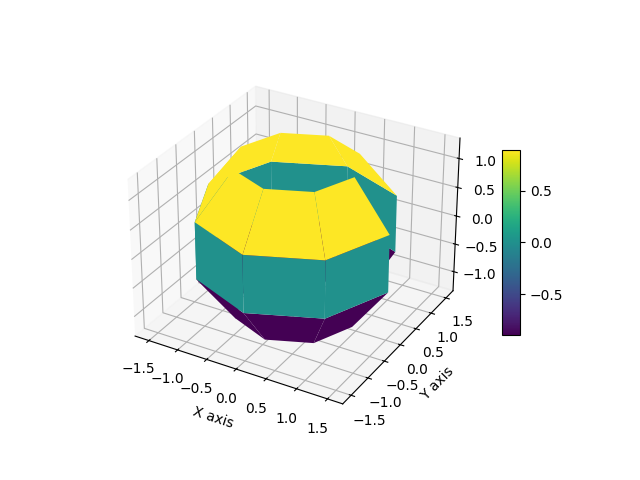

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Example data for xx, yy, zz


# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(xx, yy, zz, cmap='viridis')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the plot
plt.show()

In [ ]:
sphere_base = 

In [ ]:
mfs_data.collocation.phi_grid

array([[0.78539816, 0.78539816, 0.78539816, 0.78539816],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633],
       [2.35619449, 2.35619449, 2.35619449, 2.35619449],
       [3.14159265, 3.14159265, 3.14159265, 3.14159265],
       [3.92699082, 3.92699082, 3.92699082, 3.92699082],
       [4.71238898, 4.71238898, 4.71238898, 4.71238898],
       [5.49778714, 5.49778714, 5.49778714, 5.49778714],
       [6.28318531, 6.28318531, 6.28318531, 6.28318531]])

In [ ]:
mfs_data.collocation.theta_grid

array([[0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412]])

In [ ]:
mfs_data.collocation

In [ ]:
rf(collocation.theta_grid, collocation.phi_grid)

In [ ]:
from gpbr.direct.common.boundary import StarlikeSurface

Gamma1 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r1, dr1)
Gamma2 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r2, dr2)

In [ ]:
Gamma1_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA1*r1(s))
Gamma2_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA2*r2(s))

In [ ]:
from gpbr.direct.common.source import SourcePoints2D
source_points = SourcePoints2D(Gamma1_source.collocation.n+Gamma2_source.collocation.n, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)

In [ ]:
## Plot
import matplotlib.pyplot as plt
def plot_normals(G2: StarlikeSurface):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    g2_x, g2_y = G2.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')
    ax_plot.plot(g2_x, g2_y, 'r--')

    for sp in source:
        ax_plot.plot(sp.x, sp.y, 'bo')

    # Plot normal vectors
    for p, n in zip(G1.points, G1.normals):
        ax_plot.quiver(p.x, p.y, n.x, n.y, color='blue', scale=15)

    for p, n in zip(G2.points, G2.normals):
        ax_plot.quiver(p.x, p.y, n.x, n.y, color='red', scale=15)

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
plot_2d(Gamma1, Gamma2, source_points)

In [ ]:
from gpbr.direct.common.boundary import Point2D
from gpbr.direct.common.distance import point_distance
def u2de(xp, t):
    point = Point2D(0,4)
    dist =point_distance(point, xp)
    return 1/4/np.pi/t*np.exp(-dist**2/4/t)
    

In [ ]:
from gpbr.direct.common.boundary import Point2D

def f1(x: Point2D , t: float) -> float:
    return u2de(x, t)

def f2(x: Point2D, t: float) -> float:
    return u2de(x, t)

In [ ]:
from gpbr.direct.heat_equation.common import MFSConfig
T = 1 # final time
N = 10 # N+1=10 time points
M = 16 # number of collocation and points
ETA1 = 0.5
ETA2 = 2.0
config = MFSConfig(
    N=N,
    n_coll=M,
    n_source=M,
    T=T,
    eta1=ETA1,
    eta2=ETA2,
    f1=f1,
    f2=f2
)


In [ ]:
from gpbr.direct.heat_equation.helpers import precalculate_mfs_data
mfs_data = precalculate_mfs_data(config)

In [ ]:
def r2(theta, phi):
    return 2+np.sqrt(4.25+3*np.cos(3*theta))

def dr2(s):
    return 0

In [ ]:
2 + sqrt(4.25+3*cos(3*theta))

In [ ]:
from gpbr.direct.common.boundary import StarlikeCurve, starlike_circle_base, starlike_curve
Gamma2 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r2, dr2)
Gamma2_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA2*r2(s))

In [ ]:
from gpbr.direct.common.source import SourcePoints2D
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d
from gpbr.direct.heat_equation.helpers import dbu_2d

from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs
from numpy.linalg import lstsq


def eval_for_g1(
        Gamma2: StarlikeCurve,
        Gamma2_source: StarlikeCurve,
        f1, f2,
        mfs_data,
        r1_func
    ):
    Gamma1 = StarlikeCurve.from_radial(mfs_data.collocation, r1_func)
    Gamma1_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA1*r1_func(s))
    source_points = SourcePoints2D(Gamma1_source.collocation.n+Gamma2_source.collocation.n, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)


    fundamental_sequence_gamma1 = fundamental_sequence_2d(Gamma1, source_points, mfs_data)
    fundamental_sequence_gamma2 = fundamental_sequence_2d(Gamma2, source_points, mfs_data)
    PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)


    alpha_coeeff = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    alpha_coeeff[:] = np.nan
    fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
    for n in range(0, mfs_data.N+1):
        F = form_fs_vector_2d(n,
                            fundamental_sequence_gamma1,
                            fundamental_sequence_gamma2,
                            Gamma1,
                            Gamma2,
                            fs_coefs,
                            f1, f2, mfs_data)
        alpha_n = lstsq(PHI_MAT, F)[0]
        fs_coefs.alpha[n] = alpha_n.T

    du_vals = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    for n in range(0, N+1):
        for i, (x, nx) in enumerate(zip(Gamma2.points, Gamma2.normals)):
            du_vals[n, i] = dbu_2d(x, nx, n, source_points, fs_coefs, mfs_data)
    return du_vals

    

In [ ]:
# def r1(s):
#     return 0.8
def r1(s):
    return np.sqrt(np.cos(s)**2 + np.sin(s)**2/4)

exact = eval_for_g1(Gamma2, Gamma2_source, f1, f2, mfs_data, r1)

In [ ]:
import matplotlib.pyplot as plt

def plot_g1(G1):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()


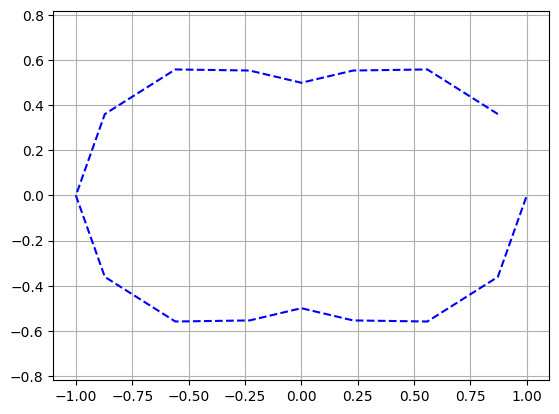

In [ ]:
G1_plot = StarlikeCurve.from_radial(mfs_data.collocation, r1)
plot_g1(G1_plot)

In [ ]:
from scipy import integrate

def calc_l2_norm(ncoll, tn, exact, approx):
    return np.sqrt(integrate.trapezoid(np.sum((approx-exact)**2, axis=1), tn)*(2*np.pi)/(ncoll))


In [ ]:
def feasable(ext_boundary, rfunc, rvals):
    if abs(rfunc(0) - rfunc(2*np.pi)) > 1e-6:
        return False

    if np.any(np.less(rvals, 0.0)):
        return False

    if np.any(np.greater_equal(rvals, ext_boundary)):
        return False
    
    return True

In [ ]:
import random
from deap import creator, base, tools, algorithms, gp

In [ ]:
import functools
import math, operator

pset = gp.PrimitiveSet("main", 1)
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.cos, 1)
pset.addPrimitive(np.sin, 1)
pset.addEphemeralConstant('rand', (np.random.rand, 1)[0])

pset.renameArguments(ARG0="s")

In [ ]:
import random
from deap import creator, base, tools, algorithms
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [ ]:
toolbox = base.Toolbox()
# toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)

In [ ]:
# toolbox.register('evaluate', eval_for_g1, Gamma2=Gamma2, Gamma2_source=Gamma2_source, f1=f1, f2=f2, mfs_data=mfs_data)
toolbox.register('feasable', feasable, 1.6)
toolbox.register('calc_normals', eval_for_g1, Gamma2, Gamma2_source, f1, f2, mfs_data)
toolbox.register('norm', calc_l2_norm, mfs_data.M, mfs_data.tn, exact)
toolbox.register('plot', plot_g1)

In [ ]:
def evaluate(mfsd, tlb, ind):
    # print(ind)
    ind_compile = tlb.compile(expr=ind)
    ind_values = ind_compile(mfsd.collocation.theta)
    if not toolbox.feasable(ind_compile, ind_values):
        return (1e6, )

    g2_approx = toolbox.calc_normals(ind_compile)
    return (toolbox.norm(g2_approx), )

In [ ]:
toolbox.register('evaluate', evaluate, mfs_data, toolbox)


In [ ]:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [ ]:

# random.seed(318)

pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                            halloffame=hof, verbose=True)

   	      	                       fitness                        	                      size                     
   	      	------------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max  	min        	nevals	std   	avg 	gen	max	min	nevals	std    
0  	50    	720000	0  	1e+06	4.34443e-06	50    	448999	8.56	0  	33 	2  	50    	8.47151
1  	32    	460000	1  	1e+06	4.34443e-06	32    	498397	6.68	1  	33 	1  	32    	7.22064
2  	30    	260000	2  	1e+06	4.34443e-06	30    	438634	5.28	2  	30 	2  	30    	5.12656
3  	21    	40000 	3  	1e+06	5.03397e-07	21    	195959	3.62	3  	8  	2  	21    	1.73078
4  	23    	80000 	4  	1e+06	5.03397e-07	23    	271293	3.2 	4  	8  	2  	23    	1.23288
5  	30    	60000 	5  	1e+06	5.03397e-07	30    	237487	3.1 	5  	5  	1  	30    	0.984886
6  	22    	100000	6  	1e+06	5.03397e-07	22    	300000	3.18	6  	5  	1  	22    	0.84119 
7  	28    	140000	7  	1e+06	5.03397e-07	28    	346987	3.32	7  	7  	2  	28    	0.96

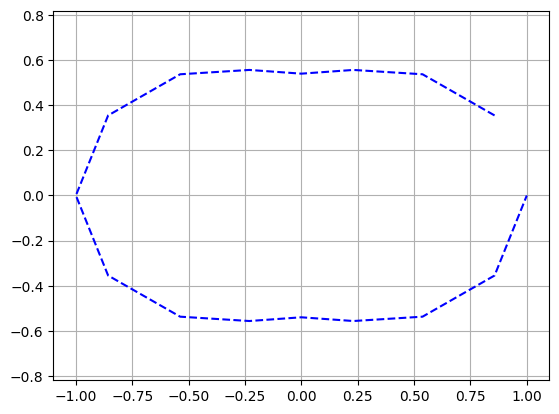

In [ ]:
G1_test = StarlikeCurve.from_radial(mfs_data.collocation, toolbox.compile(expr=hof[0]))
toolbox.plot(G1_test)

In [ ]:
print(hof[0])

cos(sin(s))


In [ ]:
assert False

AssertionError: 

In [ ]:
import matplotlib.pyplot as plt

def plot_g1(G1):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
toolbox.register('plot', plot_g1)

add(sin(cos(sin(sin(s)))), sin(add(sin(add(0.35154652343713955, s)), cos(multiply(s, s)))))
multiply(s, s)
multiply(sin(multiply(cos(sin(s)), cos(sin(0.6149477194972331)))), cos(multiply(multiply(sin(0.5180465030210641), sin(0.04959337865745339)), add(cos(0.7573324363233912), cos(s)))))
1.552991909080186e-05


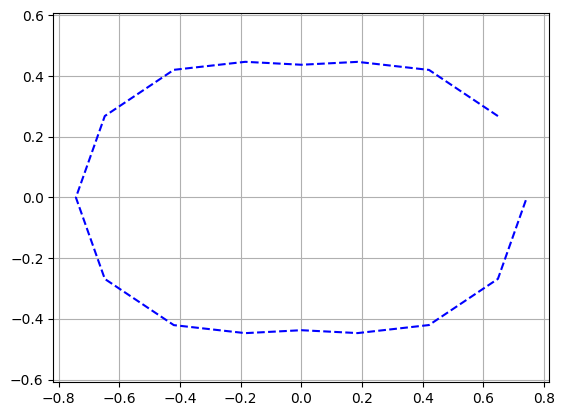

---------------------------------------------------------------------------
sin(add(0.12037073509728358, s))
multiply(cos(sin(sin(s))), sin(cos(multiply(0.9350739033069126, s))))
multiply(0.30813773366873853, multiply(s, 0.5089915652036325))
sin(multiply(sin(sin(s)), cos(sin(0.7359000640387753))))
sin(cos(s))
cos(cos(sin(multiply(add(s, 0.3677084696698829), cos(0.10533105821766908)))))
multiply(cos(sin(add(add(0.2638132373849562, s), add(0.10490388560245512, s)))), add(cos(multiply(cos(s), cos(0.2460418822655981))), sin(cos(cos(0.014921757807564773)))))
4.5364073068500464e-05


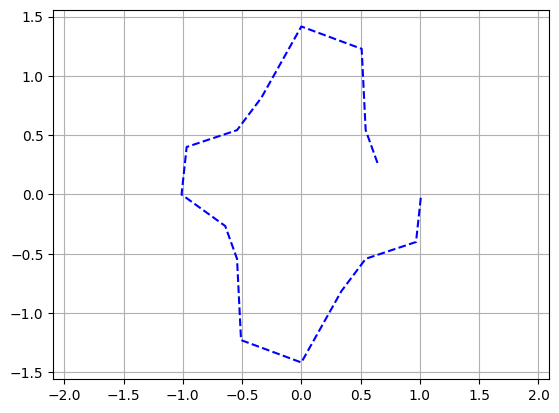

---------------------------------------------------------------------------
cos(multiply(s, 0.3100523103549573))
sin(cos(cos(0.9222110602541755)))
5.2655661052626634e-06


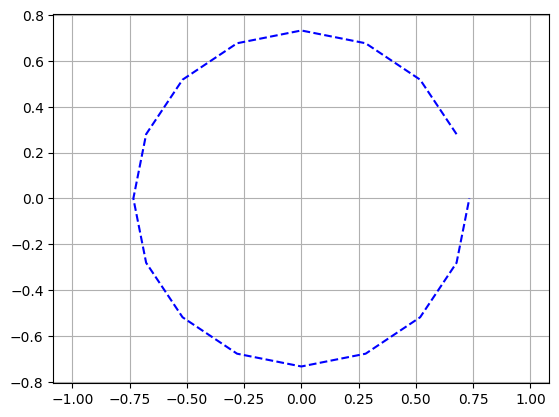

---------------------------------------------------------------------------
add(cos(cos(multiply(s, s))), cos(cos(add(s, s))))
add(add(0.2611738351753442, 0.6121529504174111), cos(0.9793584348178721))
0.0005761421736524605


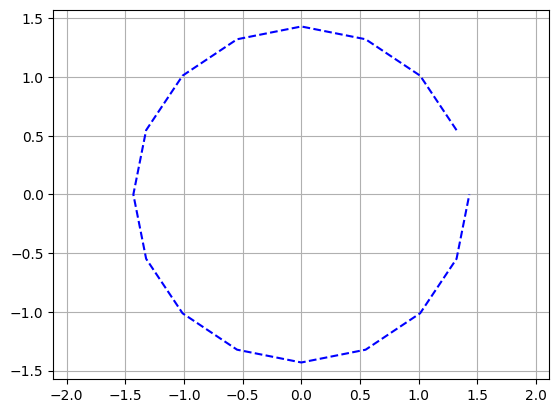

---------------------------------------------------------------------------
add(cos(add(cos(s), multiply(s, s))), sin(sin(sin(s))))
multiply(multiply(add(cos(multiply(0.6669384554290868, s)), add(sin(s), add(s, s))), add(add(multiply(0.5176719646519707, 0.39932071098154875), sin(0.5059969639592864)), sin(add(s, 0.5311130120151062)))), add(cos(add(add(s, s), add(0.3360314517930926, 0.9762579352641558))), cos(multiply(add(s, s), multiply(s, s)))))
sin(s)
sin(cos(s))
sin(0.2247570555588566)
1.8560087625195784e-05


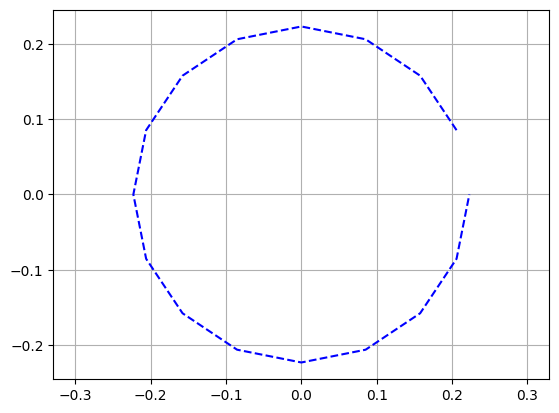

---------------------------------------------------------------------------
cos(sin(sin(multiply(0.07063018514010444, s))))
multiply(0.23193011712783884, s)
multiply(add(sin(add(add(0.2869928392479212, 0.38413556245851455), add(0.2552412992449399, 0.17387039993720643))), cos(add(add(0.32301124823684824, 0.8400653216479955), multiply(0.7439388735838811, s)))), add(cos(sin(multiply(0.2913194259331081, 0.5486672013021568))), cos(cos(add(s, 0.1048308758173726)))))
sin(s)
add(sin(sin(0.9371961008138076)), add(cos(s), add(0.7380477674822958, s)))
add(sin(multiply(cos(add(0.8658354152708848, s)), add(multiply(0.569574066766192, s), sin(s)))), multiply(sin(sin(sin(0.3227334007824313))), cos(multiply(cos(0.8650242575779415), add(s, s)))))
multiply(sin(s), sin(s))
7.204022212542782e-06


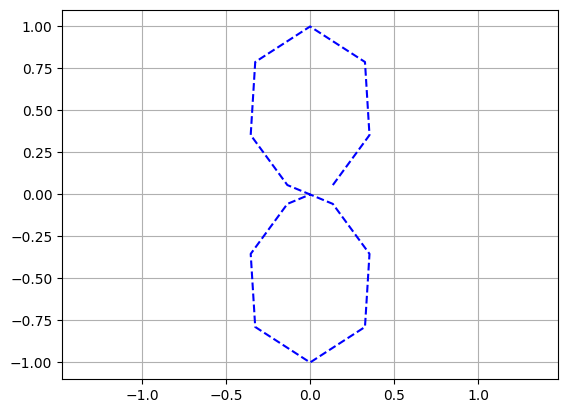

---------------------------------------------------------------------------
sin(s)
sin(s)
cos(0.11345235045793656)
2.6386411681343252e-05


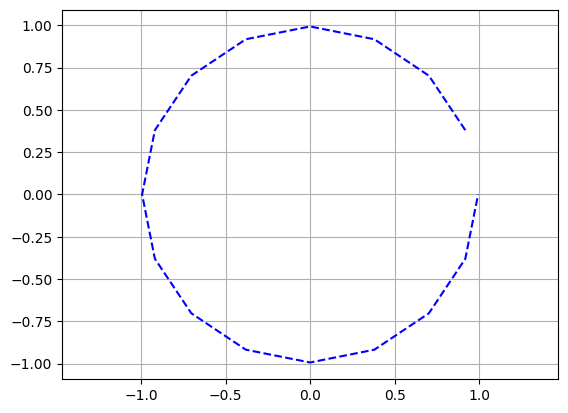

---------------------------------------------------------------------------
sin(s)
sin(s)
sin(multiply(cos(0.296752823510109), multiply(multiply(s, 0.686582019226399), add(s, 0.3039228594036216))))
multiply(sin(sin(add(add(0.361565926237704, s), sin(s)))), sin(add(cos(add(s, 0.8748001286585986)), add(multiply(0.7717659769299718, 0.4902974811827907), cos(0.8221172444727883)))))
add(0.18616114508721093, multiply(s, 0.3590137773722407))
add(sin(cos(s)), cos(multiply(0.23563309516326048, s)))
multiply(s, s)
add(0.09660511852276721, sin(cos(0.866260916398649)))
7.40417016959267e-06


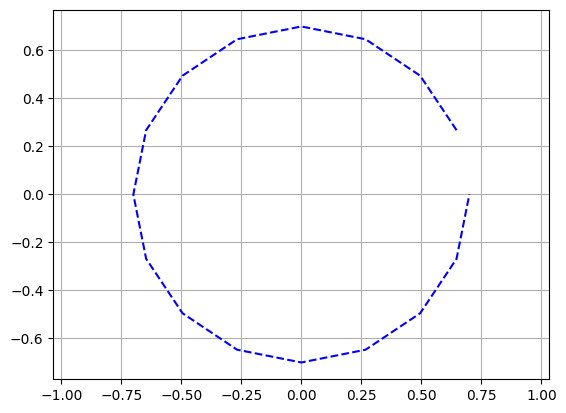

---------------------------------------------------------------------------
add(cos(sin(0.9508048925802135)), s)
multiply(add(sin(s), add(s, 0.493843121351071)), add(add(s, s), sin(0.30927110591223195)))
multiply(sin(s), multiply(s, 0.9787066940900057))
sin(multiply(s, s))
add(cos(s), add(sin(s), sin(add(s, 0.7970850234640509))))
cos(s)
cos(0.7130791641665306)
3.5984995114309576e-06


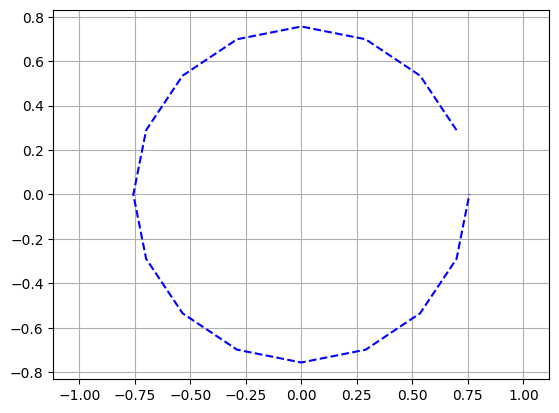

---------------------------------------------------------------------------
multiply(add(multiply(cos(cos(0.3772565565794904)), cos(multiply(0.052206353644035475, 0.4877777538655037))), sin(cos(cos(s)))), multiply(add(cos(cos(0.4040309467767673)), cos(multiply(0.16730545174759037, s))), add(sin(cos(0.8932669594490584)), add(add(0.057518431890260624, s), cos(0.74848928074168)))))
add(cos(s), multiply(s, s))
multiply(add(multiply(sin(sin(0.13951586845256347)), add(cos(0.5376215812145829), sin(s))), add(sin(sin(s)), add(sin(s), cos(s)))), sin(multiply(sin(multiply(s, 0.8373884974810512)), cos(add(s, s)))))
cos(sin(sin(0.032811890774947394)))
2.7575424503907682e-05


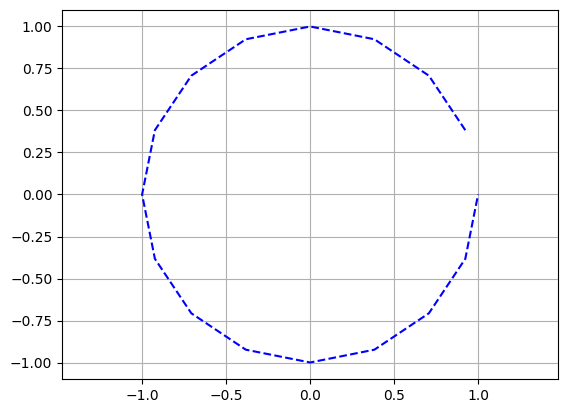

---------------------------------------------------------------------------
cos(s)
add(sin(s), cos(s))


In [ ]:
from scipy import integrate
for ind in toolbox.population(n=50):
    ind_compile = toolbox.compile(expr=ind)
    ind_values = ind_compile(mfs_data.collocation.theta)
    print(ind)

    if not toolbox.feasable(ind_compile, ind_values):
        continue

    G1_test = StarlikeCurve.from_radial(mfs_data.collocation, ind_compile)
    g1_approx = toolbox.evaluate(ind_compile)
    print(toolbox.norm(g1_approx))
    toolbox.plot(G1_test)
    print('---------------------------------------------------------------------------')

In [ ]:
assert Fals

NameError: name 'Fals' is not defined

In [ ]:
import numpy as np

# Define the parametric function r(theta)
def r(theta):
    return np.sin(theta) + np.sin(0.11352607057693409)
    return np.sin(np.cos(2*theta))
    # sin(cos(add(s, s)))

    # Example: r(theta) = 1 + 0.5 * np.sin(5 * theta)
    return 1 + 0.5 * np.sin(5 * theta)

# Define the number of samples
num_samples = 1000

# Generate theta values
theta_values = np.linspace(0, 2 * np.pi, num_samples)

# Convert to Cartesian coordinates
x_values = r(theta_values) * np.cos(theta_values)
y_values = r(theta_values) * np.sin(theta_values)

# Check for intersections
tolerance = 1e-6
intersections = []

for i in range(num_samples):
    for j in range(i + 1, num_samples):
        if np.abs(x_values[i] - x_values[j]) < tolerance and np.abs(y_values[i] - y_values[j]) < tolerance:
            intersections.append((theta_values[i], theta_values[j]))

print("Self-intersections:", intersections)

Self-intersections: [(np.float64(0.0), np.float64(6.283185307179586))]


In [ ]:
import sympy as sp

# Define the parameter
theta = sp.symbols('theta')

# Define the parametric equations for the starlike curve
r = sp.Function('r')(theta)
x = r * sp.cos(theta)
y = r * sp.sin(theta)

# Define another parameter for comparison
theta2 = sp.symbols('theta2')

# Equations for self-intersection
eq1 = sp.Eq(x.subs(theta, theta), x.subs(theta, theta2))
eq2 = sp.Eq(y.subs(theta, theta), y.subs(theta, theta2))

print("Equation 1:", eq1)
print("Equation 2:", eq2)

Equation 1: Eq(r(theta)*cos(theta), r(theta2)*cos(theta2))
Equation 2: Eq(r(theta)*sin(theta), r(theta2)*sin(theta2))


In [ ]:
ind = toolbox.individual()
print(ind)

sin(cos(cos(-0.12333206376883887)))


In [ ]:
toolbox.compile(ind)(0)

0.5198524963998898

In [ ]:
G1_test = StarlikeCurve.from_radial(mfs_data.collocation, toolbox.compile(ind))

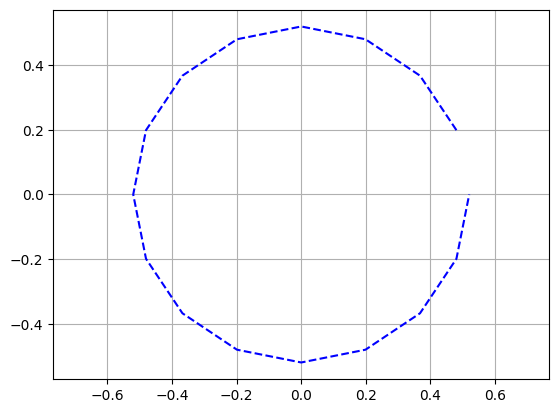

In [ ]:
import matplotlib.pyplot as plt

fig_plot, ax_plot = plt.subplots()
g1_x, g1_y = G1_test.raw_points()
ax_plot.plot(g1_x, g1_y, 'b--')

ax_plot.axis('equal')
plt.grid()
plt.show()
plt.close()

In [ ]:
toolbox.evaluate(toolbox.compile(ind))[0]

array([-9.05432844e-09, -3.93603090e-08,  1.10901463e-07,  5.08693740e-07,
        1.10901463e-07, -3.93603090e-08, -9.05432844e-09,  4.62317030e-09,
        1.03377094e-09, -5.54408448e-10, -1.07784648e-10,  1.29111809e-10,
       -1.07784648e-10, -5.54408448e-10,  1.03377094e-09,  4.62317030e-09])

In [ ]:
def r1(s):
    return 0.8

In [ ]:
def r1(s):
    return 0.8
exact = eval_for_g1(Gamma2, Gamma2_source, f1, f2, mfs_data, r1)

In [ ]:
np.linalg.norm(toolbox.evaluate(toolbox.compile(ind))-res)

np.float64(8.227235313857608e-05)

In [ ]:
assert False

AssertionError: 

In [ ]:
from gpbr.direct.common.boundary import StarlikeCurve, starlike_circle_base, starlike_curve
Gamma1 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r1, dr1)
Gamma2 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r2, dr2)

In [ ]:
Gamma1_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA1*r1(s))
Gamma2_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA2*r2(s))

In [ ]:
from gpbr.direct.common.source import SourcePoints2D
source_points = SourcePoints2D(Gamma1_source.collocation.n+Gamma2_source.collocation.n, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)

In [ ]:
## Plot
import matplotlib.pyplot as plt
def plot_2d(G1: StarlikeCurve, G2: StarlikeCurve, source):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    g2_x, g2_y = G2.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')
    ax_plot.plot(g2_x, g2_y, 'r--')

    for sp in source:
        ax_plot.plot(sp.x, sp.y, 'bo')

    # Plot normal vectors
    for p, n in zip(G1.points, G1.normals):
        ax_plot.quiver(p.x, p.y, n.x, n.y, color='blue', scale=15)

    for p, n in zip(G2.points, G2.normals):
        ax_plot.quiver(p.x, p.y, n.x, n.y, color='red', scale=15)

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()

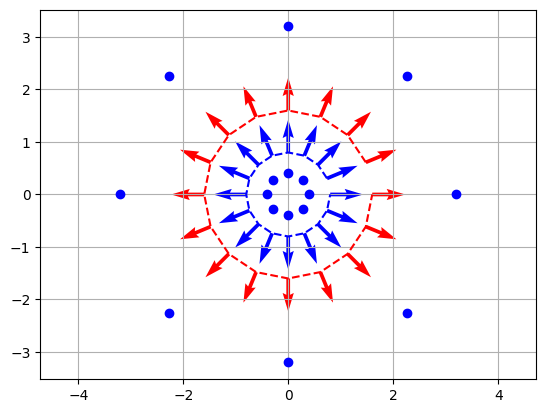

In [ ]:
plot_2d(Gamma1, Gamma2, source_points)

In [ ]:
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence

fundamental_sequence_gamma1 = fundamental_sequence_2d(Gamma1, source_points, mfs_data)
fundamental_sequence_gamma2 = fundamental_sequence_2d(Gamma2, source_points, mfs_data)

In [ ]:
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d
PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)
PHI_MAT.shape

(32, 16)

In [ ]:
PHI_MAT

array([[3.23010230e-06, 2.73551713e-07, 1.52446781e-08, 2.58827313e-09,
        2.58827313e-09, 1.52446781e-08, 2.73551713e-07, 3.23010230e-06,
        9.56681371e-02, 1.97206881e-02, 4.62463023e-03, 2.06453154e-03,
        2.06453154e-03, 4.62463023e-03, 1.97206881e-02, 9.56681371e-02],
       [4.77387264e-06, 1.13397585e-06, 6.03684693e-08, 5.15584128e-09,
        2.04417089e-09, 5.15584128e-09, 6.03684693e-08, 1.13397585e-06,
        1.32712453e-01, 4.56599531e-02, 8.97493161e-03, 2.81006458e-03,
        1.86004541e-03, 2.81006458e-03, 8.97493161e-03, 4.56599531e-02],
       [3.23010230e-06, 3.23010230e-06, 2.73551713e-07, 1.52446781e-08,
        2.58827313e-09, 2.58827313e-09, 1.52446781e-08, 2.73551713e-07,
        9.56681371e-02, 9.56681371e-02, 1.97206881e-02, 4.62463023e-03,
        2.06453154e-03, 2.06453154e-03, 4.62463023e-03, 1.97206881e-02],
       [1.13397585e-06, 4.77387264e-06, 1.13397585e-06, 6.03684693e-08,
        5.15584128e-09, 2.04417089e-09, 5.15584128e-09, 6.036

In [ ]:
from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs

alpha_coeeff = np.empty((N+1, M), dtype=np.float64)
alpha_coeeff[:] = np.nan
fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
from numpy.linalg import lstsq
for n in range(0, N+1):
    F = form_fs_vector_2d(n,
                          fundamental_sequence_gamma1,
                          fundamental_sequence_gamma2,
                          Gamma1,
                          Gamma2,
                          fs_coefs,
                          f1, f2, mfs_data)
    alpha_n = lstsq(PHI_MAT, F)[0]
    fs_coefs.alpha[n] = alpha_n.T
    print(fs_coefs.alpha)

[[-3.44641541e-05  4.11424213e-04 -3.44641541e-05  3.96950906e-06
  -4.74538782e-07  1.10469035e-07 -4.74538782e-07  3.96950906e-06
   3.17577496e-09 -1.72032226e-08  3.17577496e-09  1.06793030e-10
  -6.24306943e-11  1.72986657e-10 -6.24306944e-11  1.06793030e-10]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
       

In [ ]:
from gpbr.direct.common.boundary import Point2D
test_points = [Point2D(0.0, 0.98), Point2D(1.0, -0.73), Point2D(0.51, 0.54), Point2D(-0.501, 0.52), Point2D(-1.11, -0.75), Point2D(0.0, -1.0)]

In [ ]:
from gpbr.direct.heat_equation.helpers import u_2d
for n in range(0, N+1):
    print(f'N={n}')
    for p in test_points:
        u_approx = u_2d(p, n, source_points, fs_coefs, mfs_data)
        u_exact = u2de(p, mfs_data.tn[n])
        print(f'Difference: {abs(u_approx - u_exact)}')
        # print(f'u_approx={u_approx}, u_exact={u_exact}')

N=0
Difference: 3.9066794856549646e-09
Difference: 8.51513042226721e-12
Difference: 1.4972768660576572e-10
Difference: 1.784626575871667e-10
Difference: 1.6793872784732295e-11
Difference: 1.2189477131944364e-12
N=1
Difference: 4.637200256570756e-06
Difference: 4.082887220502182e-09
Difference: 2.7556587717559586e-07
Difference: 3.606114036715847e-07
Difference: 8.013144333423416e-09
Difference: 1.0340333348292328e-09
N=2
Difference: 1.6954070569315163e-05
Difference: 8.941498587993755e-10
Difference: 2.359846584382767e-06
Difference: 3.3125333428670937e-06
Difference: 5.1627702874703165e-09
Difference: 8.369990591347335e-09
N=3
Difference: 3.1544692111930696e-06
Difference: 1.4359394240284083e-07
Difference: 2.7907566271862574e-06
Difference: 3.983583734547264e-06
Difference: 3.1924337417955055e-07
Difference: 1.706349759139021e-08
N=4
Difference: 1.4350362108491192e-05
Difference: 7.250690113106045e-07
Difference: 1.7767428816745155e-07
Difference: 3.5547598110902525e-07
Difference: 1

In [ ]:
def du2de_vec(xp, t):
    # -0.125*x1*exp((-x1**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)
    # 0.25*(2 - x2/2)*exp((-x1**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)
    return Point2D(
        -0.125*xp.x*np.exp((-xp.x**2/4 - (xp.y - 4)**2/4)/t)/(np.pi*t**2),
        0.25*(2 - xp.y/2)*np.exp((-xp.x**2/4 - (xp.y  - 4)**2/4)/t)/(np.pi*t**2)
    )
    

In [ ]:
from gpbr.direct.heat_equation.helpers import dbu_2d
for n in range(0, N+1):
    print(f'N={n}')
    norms = []
    for x, nx in zip(Gamma1.points, Gamma1.normals):
        du_approx = dbu_2d(x, nx, n, source_points, fs_coefs, mfs_data)
        du_e_vec = du2de_vec(x, mfs_data.tn[n])
        du_exact = du_e_vec.x*nx.x + du_e_vec.y*nx.y
        norms.append(abs(du_approx - du_exact))
    print(f'Max difference: {max(norms)}')
    # print(f'Max difference: {np.linalg.norm(norms)}')

N=0
Max difference: 2.1293264769387242e-08
N=1
Max difference: 2.7373373781358973e-05
N=2
Max difference: 0.00012213307444786914
N=3
Max difference: 4.7619616816044685e-05
N=4
Max difference: 0.00013522181580476146
N=5
Max difference: 0.0001845660403924994
N=6
Max difference: 0.00018640978710150226
N=7
Max difference: 0.00017117954795992704
N=8
Max difference: 0.0001488915819131357
N=9
Max difference: 0.00013303996453409468
N=10
Max difference: 0.00011486626441451452
